# Imports 

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier


from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt

import gzip
import glob
import json

import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as ss

import matplotlib.pyplot as plt

from collections import Counter
%matplotlib inline
run_title = "baseline"

# Maps


#### Import TRECIS-2020-A.topics

In [2]:
# --------------------------------------------------
# Static data for the 2019 edition
# --------------------------------------------------

# Identifiers for the test events
eventIdentifiers = [
    "athensEarthquake2020",
    "baltimoreFlashFlood2020",
    "brooklynBlockPartyShooting2020",
    "daytonOhioShooting2020",
    "elPasoWalmartShooting2020",
    "gilroygarlicShooting2020",
    "hurricaneBarry2020",
    "indonesiaEarthquake2020",
    "keralaFloods2020",
    "myanmarFloods2020",
    "papuaNewguineaEarthquake2020",
    "siberianWildfires2020",
    "typhoonKrosa2020",
    "typhoonLekima2020",
    "whaleyBridgeCollapse2020"
]

eventidTopicidMap =	{
  "athensEarthquake2020": "TRECIS-CTIT-H-Test-035", #earthquake
  "baltimoreFlashFlood2020": "TRECIS-CTIT-H-Test-036", #flood
  "brooklynBlockPartyShooting2020": "TRECIS-CTIT-H-Test-037", #shooting
  "daytonOhioShooting2020": "TRECIS-CTIT-H-Test-038", #shooting
  "elPasoWalmartShooting2020": "TRECIS-CTIT-H-Test-039", #shooting
  "gilroygarlicShooting2020": "TRECIS-CTIT-H-Test-040", #shooting
  "hurricaneBarry2020": "TRECIS-CTIT-H-Test-041", #hurricane
  "indonesiaEarthquake2020": "TRECIS-CTIT-H-Test-042", #earthquake
  "keralaFloods2020": "TRECIS-CTIT-H-Test-043", #flood
  "myanmarFloods2020": "TRECIS-CTIT-H-Test-044", #flood
  "papuaNewguineaEarthquake2020": "TRECIS-CTIT-H-Test-045", #earthquake
  "siberianWildfires2020": "TRECIS-CTIT-H-Test-046", #fire
  "typhoonKrosa2020": "TRECIS-CTIT-H-Test-047", #typhoon
  "typhoonLekima2020": "TRECIS-CTIT-H-Test-048",#typhoon
  "whaleyBridgeCollapse2020": "TRECIS-CTIT-H-Test-049" #failure
}

# What we consider to be highly important categories of information
highImportCategories = [
    "Request-GoodsServices",
    "Request-SearchAndRescue",
    "CallToAction-MovePeople",
    "Report-EmergingThreats",
    "Report-NewSubEvent",
    "Report-ServiceAvailable"
]

highImportCategoriesShort = [
    "GoodsServices",
    "SearchAndRescue",
    "MovePeople",
    "EmergingThreats",
    "NewSubEvent",
    "ServiceAvailable"
]

header_map = {
    "Donations": "CallToAction-Donations",
    "MovePeople": "CallToAction-MovePeople",
    "Volunteer": "CallToAction-Volunteer",
    "Advice": "Other-Advice",
    "ContextualInformation": "Other-ContextualInformation",
    "Discussion": "Other-Discussion",
    "Irrelevant": "Other-Irrelevant",
    "Sentiment": "Other-Sentiment",
    "CleanUp": "Report-CleanUp",
    "EmergingThreats": "Report-EmergingThreats",
    "Factoid": "Report-Factoid",
    "FirstPartyObservation": "Report-FirstPartyObservation",
    "Hashtags": "Report-Hashtags",
    "Location": "Report-Location",
    "MultimediaShare": "Report-MultimediaShare",
    "News": "Report-News",
    "NewSubEvent": "Report-NewSubEvent",
    "Official": "Report-Official",
    "OriginalEvent": "Report-OriginalEvent",
    "ServiceAvailable": "Report-ServiceAvailable",
    "ThirdPartyObservation": "Report-ThirdPartyObservation",
    "Weather": "Report-Weather",
    "GoodsServices": "Request-GoodsServices",
    "InformationWanted": "Request-InformationWanted",
    "SearchAndRescue": "Request-SearchAndRescue",
}

## Topics

eventidTopicidMap = {}

with open("../../../../data/raw/data/2020/2020-A/topics/TRECIS-2020-A.topics", "r") as in_file:
    topic_num = ""
    topic_id = ""
    
    for line in in_file:
        
        if line.strip() == "</top>":
            eventidTopicidMap[topic_id] = topic_num
        
        if line.startswith("<num>"):
            topic_num = line.partition(">")[-1].partition("<")[0]
              
        if line.startswith("<dataset>"):
            topic_id = line.partition(">")[-1].partition("<")[0]

#eventidTopicidMap

### Read All Assessor Responses
Read the responses for each assessor and append them to an array of assessor data

In [46]:
# Annotated Data
annotators_data = []

def read_annotations(in_f_path):
    l_annotators_data = []
    
    with open(in_f_path, "rb") as in_file:
        annotator_content = in_file.read().decode("latin-1")
        trecis_training = json.loads(annotator_content)
        l_annotators_data.append(trecis_training)
        
    return l_annotators_data

# Read 2018 training file
in_f_path = "../../../../data/raw/data/2018/training/TRECIS-CTIT-H-Training.json"
annotators_data.extend(read_annotations(in_f_path))
        
# Read each assessor file
for in_f_path in glob.iglob("../../data/raw/data/2020/2020-A/labels/TRECIS-*.json"):
    annotators_data.extend(read_annotations(in_f_path))
    
# 2019 Labels
for in_f_path in glob.iglob("../../data/raw/data/2019A/2019ALabels/*assr*.json"):
    annotators_data.extend(read_annotations(in_f_path))

    
print("Annotations:", len(annotators_data))
print(annotators_data)

Annotations: 1
[{'annotator': {'eventsAnnotated': [{'identifier': 'costaRicaEarthquake2012', 'name': 'CrisisLex26 2012 Costa Rica Earthquake', 'description': 'The 2012 Costa Rica earthquake occurred at 08:42 local time (14:42 UTC) on September 5. The epicenter of the 7.6 Mw earthquake was in the Nicoya Peninsula, 11 kilometers east-southeast of Nicoya.', 'type': 'Unknown', 'imageURL': 'https://upload.wikimedia.org/wikipedia/commons/3/38/2012eartquakeincostarica.jpg', 'annotationTableName': 'TEA-costaRicaEarthquake2012'}, {'identifier': 'fireColorado2012', 'name': 'CrisisLex26 2012 Colorado wildfires', 'description': 'The 2012 Colorado wildfires were an unusually devastating series of Colorado wildfires, including several separate fires that occurred throughout June, July, and August 2012. At least 34,500 residents were evacuated in June.', 'type': 'Unknown', 'imageURL': 'https://upload.wikimedia.org/wikipedia/commons/e/ec/High_Park_Wildfire_Arapaho_and_Roosevelt_National_Forests_June_1

### Create the Category and Priority Maps

- This maps the tweets from the training data to category priority/maps using their `tweet_id`


In [49]:
tweet_to_category = []
tweet_to_priority = []


# category_df
for annotator in annotators_data:
    local_events = annotator["events"]
    print(local_events)
    for event in local_events:
        #print(event)
        for tweet in event["tweets"]:
            #print(tweet)
            
            # Pull out categories from the tweet dictionary
            for category in tweet["categories"]:
                #print(category)
                tweet_to_category.append({
                    "tweet_id": np.int64(tweet["postID"]),
                    "category": category
                })
                
            # Pull out priority, of which there should be only one
            tweet_to_priority.append({
                "tweet_id": np.int64(tweet["postID"]),
                "priority": tweet["priority"]
            })

print("Tweet to Category Map:", len(tweet_to_category))
print("Tweet to Priority Map:", len(tweet_to_priority))

category_df = pd.DataFrame(tweet_to_category)

print("Tweets with Category:", category_df["tweet_id"].value_counts().index.shape[0])

# Export to CSV
category_df.to_csv("tweet_to_category.csv", index=False)

# categoryMap()
# Maps a list of tweetIDs associated with categories

tweet_category_map = {}
category_df = pd.read_csv("tweet_to_category.csv")

cat_update_map = {
    "ContinuingNews": "News",
    "PastNews": "ContextualInformation",
    "KnownAlready": "OriginalEvent",
    "SignificantEventChange": "NewSubEvent",
}

category_df["category"] = category_df["category"].apply(lambda x: cat_update_map.get(x, x))

for category, tweets in category_df.groupby("category"):
    tweet_category_map[category] = list(tweets["tweet_id"])
    
# Deleted in 2019
del(tweet_category_map["Unknown"])

#tweet_category_map
#tweet_to_priority


[{'eventid': 'costaRicaEarthquake2012', 'tweets': [{'postID': '243377845072715777', 'categories': ['KnownAlready'], 'indicatorTerms': ['quake', 'hits'], 'priority': 'Low'}, {'postID': '243367720022855680', 'categories': ['KnownAlready'], 'indicatorTerms': ['Quake', 'Hits'], 'priority': 'Low'}, {'postID': '245776676586389504', 'categories': ['KnownAlready'], 'indicatorTerms': ['#earthquake'], 'priority': 'Low'}, {'postID': '247293697593597952', 'categories': ['KnownAlready'], 'indicatorTerms': ['Earthquake'], 'priority': 'Low'}, {'postID': '243426079547723776', 'categories': ['KnownAlready'], 'indicatorTerms': ['rocked', 'earthquake:'], 'priority': 'Low'}, {'postID': '243401194737901569', 'categories': ['Official'], 'indicatorTerms': ['Tsunami', 'warning'], 'priority': 'Low'}, {'postID': '243436699517071360', 'categories': ['KnownAlready'], 'indicatorTerms': ['quake', 'shakes'], 'priority': 'Low'}, {'postID': '243366331687256065', 'categories': ['KnownAlready'], 'indicatorTerms': ['eart

[{'tweet_id': 243377845072715777, 'priority': 'Low'},
 {'tweet_id': 243367720022855680, 'priority': 'Low'},
 {'tweet_id': 245776676586389504, 'priority': 'Low'},
 {'tweet_id': 247293697593597952, 'priority': 'Low'},
 {'tweet_id': 243426079547723776, 'priority': 'Low'},
 {'tweet_id': 243401194737901569, 'priority': 'Low'},
 {'tweet_id': 243436699517071360, 'priority': 'Low'},
 {'tweet_id': 243366331687256065, 'priority': 'Low'},
 {'tweet_id': 243378847502962688, 'priority': 'Medium'},
 {'tweet_id': 243375215244095488, 'priority': 'Low'},
 {'tweet_id': 243374590288592896, 'priority': 'Low'},
 {'tweet_id': 243461806629203969, 'priority': 'Low'},
 {'tweet_id': 243394697765199872, 'priority': 'Medium'},
 {'tweet_id': 243411898605907968, 'priority': 'Medium'},
 {'tweet_id': 243372316963254273, 'priority': 'High'},
 {'tweet_id': 243478046978473986, 'priority': 'Low'},
 {'tweet_id': 243427237188210688, 'priority': 'High'},
 {'tweet_id': 243361759912681472, 'priority': 'Low'},
 {'tweet_id': 243

# Priorities

This method...


In [5]:
# 
priority_df = pd.DataFrame(tweet_to_priority)

# Mapping of prority labels (by assessors) into numerical values [0-1]
# We use this to calculate error against the participant priority scores

priority_mapping = {
    "Critical" : 1.0,
    "High" : 0.75,
    "Medium" : 0.5,
    "Low" : 0.25,
    "Unknown" : 0.0,
}


# Merge the score 
merged_priorities = []

for tweet_id, group in priority_df.groupby("tweet_id"):
    
    #
    priority_list = list(group["priority"])
    
    #
    p_scores = [priority_mapping[p] for p in priority_list]
    
    #
    merged_priorities.append({
        "tweet_id": tweet_id,
        "priority": np.mean(p_scores),
        "score_std": np.std(p_scores),
        "score_k": len(p_scores),
    })
    
# print(merged_priorities)

# We then place these results in a dataframe to make them easier to work with 
priority_df = pd.DataFrame(merged_priorities)


# priority_df["priority"].plot.hist()
# print("Tweets with Priority:", priority_df.shape[0])
# priority_df.to_csv("tweet_to_priority.csv", index=False)

priority_df


priority_map = {row["tweet_id"]: row["priority"] for idx, row in priority_df.iterrows()}
priority_map


{2.1128197387072717e+17: 0.25,
 2.1155740123149517e+17: 0.5,
 2.115659744224256e+17: 0.75,
 2.116071876535337e+17: 0.5,
 2.116544155039908e+17: 0.5,
 2.116712472585216e+17: 0.25,
 2.1168130936865587e+17: 0.25,
 2.116856211257426e+17: 0.25,
 2.1170365661197926e+17: 0.25,
 2.1173296641671987e+17: 0.25,
 2.1179062553059328e+17: 0.25,
 2.1183075661447578e+17: 0.25,
 2.1184823846515917e+17: 0.25,
 2.1187704914773606e+17: 0.25,
 2.1188408299133338e+17: 0.75,
 2.118930168924242e+17: 0.5,
 2.1190481125009e+17: 0.5,
 2.119103225823355e+17: 0.75,
 2.1193151218096538e+17: 0.5,
 2.1195809148541747e+17: 0.5,
 2.1196419839623168e+17: 0.5,
 2.11964315853525e+17: 0.75,
 2.1196823331248538e+17: 0.5,
 2.1197193269701018e+17: 0.75,
 2.11976521278165e+17: 0.5,
 2.119919521351721e+17: 0.5,
 2.120001142465536e+17: 0.5,
 2.120029328188416e+17: 0.5,
 2.120191438037975e+17: 0.25,
 2.1202310319742157e+17: 0.25,
 2.120256869180498e+17: 0.25,
 2.120324145648804e+17: 0.5,
 2.1204659969682637e+17: 0.5,
 2.120618292

## Import High-level Information Types 

(TRECIS-2020-ITypes-Task1.json)

In [6]:
## Categories / ontologyFile

ontologydf = pd.read_json("../../../../data/raw/data/2020/2020-A/types/TRECIS-2020-ITypes-Task1.json", orient='columns')['informationTypes']

ontologydf

0     {'id': 'Request-GoodsServices', 'desc': 'The u...
1     {'id': 'Request-SearchAndRescue', 'desc': 'The...
2     {'id': 'Request-InformationWanted', 'desc': 'T...
3     {'id': 'CallToAction-Volunteer', 'desc': 'The ...
4     {'id': 'CallToAction-Donations', 'desc': 'The ...
5     {'id': 'CallToAction-MovePeople', 'desc': 'The...
6     {'id': 'Report-FirstPartyObservation', 'desc':...
7     {'id': 'Report-ThirdPartyObservation', 'desc':...
8     {'id': 'Report-Weather', 'desc': 'The user is ...
9     {'id': 'Report-Location', 'desc': 'The post co...
10    {'id': 'Report-EmergingThreats', 'desc': 'The ...
11    {'id': 'Report-NewSubEvent', 'desc': 'The user...
12    {'id': 'Report-MultimediaShare', 'desc': 'The ...
13    {'id': 'Report-ServiceAvailable', 'desc': 'The...
14    {'id': 'Report-Factoid', 'desc': 'The user is ...
15    {'id': 'Report-Official', 'desc': 'An official...
16    {'id': 'Report-News', 'desc': 'The post is a n...
17    {'id': 'Report-CleanUp', 'desc': 'A report

## Play-Framework API

In [7]:
## API
'''
import http.client

conn = http.client.HTTPConnection("localhost:9000")
conn.request("GET", "/vec")
res = conn.getresponse()
print(res.status, res.reason)

conn.close()
'''

'\nimport http.client\n\nconn = http.client.HTTPConnection("localhost:9000")\nconn.request("GET", "/vec")\nres = conn.getresponse()\nprint(res.status, res.reason)\n\nconn.close()\n'

## Feature Vector Initialisation 

In [8]:
# Dummy data

fV = [[1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565095697E12, 1.15872145345533542E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 65.0, 135.0, 0.0, 12.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56509561E12, 1.15872108884045824E18, 43.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 437.0, 679.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565095523E12, 1.15872072323142042E18, 4.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 3403.0, 4622.0, 0.0, 6.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565095511E12, 1.15872067408238592E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 215071.0, 1163.0, 0.0, 5234.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565095402E12, 1.15872021861884723E18, 1.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565095338E12, 1.15871994814913331E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 163.0, 1140.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565095335E12, 1.15871993642169958E18, 7.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 270633.0, 236910.0, 0.0, 1807.0, 0.0, 0.0, 0.0, 0.0], [1.565095008E12, 1.15871856592049766E18, 18.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 44.0, 78.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509483E12, 1.15871781931344691E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1032.0, 1421.0, 0.0, 50.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565094702E12, 1.15871728104579482E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 23.0, 50.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565094294E12, 1.1587155684150231E18, 35.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 3769.0, 816.0, 0.0, 92.0, 0.0, 0.0, 0.0, 0.0], [1.565094261E12, 1.15871543102203085E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565094169E12, 1.15871504409760154E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565093396E12, 1.15871180498761728E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 242.0, 806.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0], [1.565093369E12, 1.15871169206024192E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 174.0, 2450.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509323E12, 1.15871110571308237E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6.0, 107.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509322E12, 1.15871106626587034E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2738.0, 2654.0, 0.0, 262.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565093192E12, 1.15871094774725427E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 3574.0, 4971.0, 0.0, 5.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509245E12, 1.1587078378891264E18, 3.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 153.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565092187E12, 1.15870673105822515E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 117.0, 150.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091702E12, 1.15870469872100147E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 20116.0, 2214.0, 0.0, 71.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56509155E12, 1.15870406082172928E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 653.0, 298.0, 0.0, 81.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091544E12, 1.15870403794612224E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0], [1.56509138E12, 1.15870334691775283E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 3.0, 2.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565091344E12, 1.15870319804512256E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 364.0, 84.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091217E12, 1.15870266409345024E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 10705.0, 10722.0, 0.0, 123.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091146E12, 1.15870236757300838E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2665.0, 3273.0, 0.0, 157.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090691E12, 1.1587004600788009E18, 6.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 147.0, 770.0, 1263.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565090523E12, 1.1586997546851287E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 1167.0, 940.0, 0.0, 23.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090315E12, 1.15869888033635533E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1892.0, 1179.0, 0.0, 18.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565090169E12, 1.15869826974631526E18, 5.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 1084.0, 899.0, 0.0, 313.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565089992E12, 1.15869752745920922E18, 6.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 754.0, 63.0, 0.0, 44.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56508993E12, 1.15869726736207053E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 292.0, 19.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089899E12, 1.1586971365418967E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 465.0, 926.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089809E12, 1.15869675919696691E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508972E12, 1.15869638568598733E18, 3.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.0, 984.0, 829.0, 0.0, 61.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565089589E12, 1.15869583672290099E18, 3.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508958E12, 1.15869579993465242E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 3500.0, 3988.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0], [1.56508948E12, 1.15869537787437056E18, 19.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 537.0, 1725.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565089444E12, 1.15869522602366566E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 282.0, 284.0, 0.0, 13.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089303E12, 1.15869463559161037E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 105.0, 107.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565089203E12, 1.15869421590518579E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089168E12, 1.15869406881957069E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 69.0, 75.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089096E12, 1.15869376906525901E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2320.0, 4641.0, 0.0, 21.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565089064E12, 1.15869363269164237E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088706E12, 1.15869213438134682E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 164.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565088548E12, 1.15869146983169229E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1882.0, 4705.0, 0.0, 10.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565088386E12, 1.1586907910798295E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 181.0, 20.0, 62.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565088235E12, 1.15869015576879514E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088128E12, 1.15868970843349811E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 46.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565087954E12, 1.15868897959787725E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 128.0, 22.0, 0.0, 17.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087857E12, 1.15868857205829632E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 115.0, 173.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087717E12, 1.15868798489773261E18, 16.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 4.0, 0.0, 0.0, 0.0, 0.0, 224.0, 1603.0, 620.0, 0.0, 84.0, 0.0, 0.0, 0.0, 0.0], [1.565087265E12, 1.15868608679056998E18, 5.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.5491855E7, 70.0, 0.0, 114279.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087159E12, 1.15868564558337229E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 80.0, 0.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087109E12, 1.15868543594346086E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 50.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565086899E12, 1.15868455364646502E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 117.0, 451.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086873E12, 1.15868444440185242E18, 2.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 1.0, 0.0, 0.0, 0.0, 0.0, 237.0, 3.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565086783E12, 1.15868406809709363E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 653.0, 298.0, 0.0, 81.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086759E12, 1.15868396572270182E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 56.0, 71.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086139E12, 1.15868136649568256E18, 1.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2971.0, 3916.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0], [1.565086004E12, 1.15868079811295232E18, 1.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565085627E12, 1.15867921670503629E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 186768.0, 45.0, 0.0, 2060.0, 0.0, 0.0, 0.0, 0.0], [1.565085399E12, 1.15867826269381427E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 330.0, 238.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084663E12, 1.15867517569877197E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 68.0, 116.0, 0.0, 9.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565084639E12, 1.15867507465803366E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 4574.0, 4320.0, 0.0, 5.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084506E12, 1.15867451734823731E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 1687.0, 3784.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084226E12, 1.15867333996097536E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2432.0, 4946.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0], [1.565084189E12, 1.15867318740155597E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 128.0, 660.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084117E12, 1.15867288307129139E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 4922.0, 5241.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565083139E12, 1.15866878313051341E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1772.0, 1623.0, 0.0, 37.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56508304E12, 1.15866836567165338E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082889E12, 1.15866773506645606E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082743E12, 1.158667120630272E18, 3.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 1302.0, 5001.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0], [1.565082686E12, 1.1586668817016791E18, 5.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 3311.0, 4992.0, 0.0, 58.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565082486E12, 1.15866604197274419E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082199E12, 1.15866483931897037E18, 1.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165.0, 2888739.0, 628.0, 0.0, 22319.0, 0.0, 0.0, 0.0, 0.0], [1.565082008E12, 1.15866403947360256E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 988.0, 4996.0, 0.0, 1.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508186E12, 1.15866341676602982E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 653.0, 298.0, 0.0, 81.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565081661E12, 1.1586625852201001E18, 1.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 13406.0, 11902.0, 0.0, 168.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565081655E12, 1.15866255936656179E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 10240.0, 9119.0, 0.0, 18.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565081291E12, 1.15866103193508659E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1959.0, 2468.0, 0.0, 13.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508118E12, 1.15866056604455731E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0, 0.0, 0.0, 0.0, 193.0, 241.0, 481.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565080988E12, 1.15865976054111027E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 80.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56508098E12, 1.15865972698668237E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 19.0, 0.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565080862E12, 1.15865923355619328E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 4.2460922E7, 1107.0, 0.0, 138936.0, 0.0, 0.0, 0.0, 0.0], [1.565080733E12, 1.15865869262931558E18, 2.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5737.0, 7280.0, 0.0, 58.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565080661E12, 1.15865838738885018E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565080657E12, 1.15865837241936691E18, 3.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 148.0, 54371.0, 514.0, 0.0, 977.0, 0.0, 0.0, 0.0, 0.0], [1.565080632E12, 1.15865826877818061E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 128.0, 660.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565079616E12, 1.15865400675288269E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 65.0, 369.0, 0.0, 1.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565079572E12, 1.15865382295434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 193.0, 469.0, 0.0, 8.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565079306E12, 1.15865270791542374E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 654767.0, 8055.0, 0.0, 4906.0, 0.0, 0.0, 0.0, 0.0], [1.565079133E12, 1.15865197936462643E18, 11.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1583.0, 2329.0, 0.0, 206.0, 0.0, 0.0, 0.0, 0.0], [1.565078508E12, 1.15864935710676173E18, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 260.0, 459.0, 451.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0], [1.565078328E12, 1.15864860528624026E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 508.0, 591.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565078238E12, 1.15864822545433395E18, 2.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 2912.0, 1573.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565077898E12, 1.15864679955012403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 2110.0, 4858.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565077022E12, 1.15864312726919987E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 27726.0, 20885.0, 0.0, 398.0, 0.0, 0.0, 0.0, 0.0], [1.565076443E12, 1.15864069644791808E18, 16.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 213.0, 640.0, 619.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565076356E12, 1.15864033165257114E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 166.0, 502.0, 418.0, 0.0, 4.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565076109E12, 1.15863929826832384E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565075673E12, 1.15863746893103923E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 2804.0, 2133.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0], [1.565075362E12, 1.15863616519450624E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 266.0, 40.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565075184E12, 1.1586354178240512E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2202.0, 2629.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0], [1.565075004E12, 1.15863466305492582E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074994E12, 1.15863462050369946E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565074946E12, 1.15863441911831347E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 54.0, 1609.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074946E12, 1.15863441793557299E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 680.0, 2994.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0], [1.565074929E12, 1.1586343482891223E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 99.0, 1578.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073548E12, 1.15862855334212403E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 129.0, 0.0, 0.0, 79.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073415E12, 1.15862799861197619E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072675E12, 1.15862489517514752E18, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 527.0, 415.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565072572E12, 1.15862446232724275E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 80.0, 0.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072442E12, 1.15862391784360346E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 339.0, 556.0, 0.0, 9.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565072312E12, 1.1586233704240169E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 399.0, 250.0, 0.0, 33.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072222E12, 1.15862299503803187E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072169E12, 1.15862276951434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072104E12, 1.15862249728315802E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 22305.0, 16260.0, 0.0, 298.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565071861E12, 1.15862147857478861E18, 7.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 20.0, 67.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565071073E12, 1.15861817361826611E18, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 2.0, 0.0, 0.0, 0.0, 0.0, 191.0, 1477.0, 4991.0, 0.0, 30.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565070827E12, 1.15861714075011482E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565070617E12, 1.15861626004255949E18, 1.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 1439.0, 657.0, 0.0, 75.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069727E12, 1.1586125300103168E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 1845.0, 4942.0, 0.0, 67.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069529E12, 1.1586116962917417E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1858.0, 57.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0], [1.565069477E12, 1.1586114800671703E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565069092E12, 1.15860986498327347E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 54.0, 42.0, 0.0, 3.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565069019E12, 1.15860955991473357E18, 7.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 7042.0, 7990.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0], [1.565068388E12, 1.15860691401780019E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 223.0, 211.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067714E12, 1.15860408391529677E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 6224.0, 6475.0, 0.0, 91.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067649E12, 1.15860381119328256E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565067618E12, 1.15860368473506611E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 703804.0, 1971.0, 0.0, 1453.0, 0.0, 0.0, 0.0, 0.0], [1.565067566E12, 1.15860346646762291E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 229331.0, 538.0, 0.0, 894.0, 0.0, 0.0, 0.0, 0.0], [1.56506754E12, 1.15860335467251302E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 44953.0, 19561.0, 0.0, 680.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565067142E12, 1.1586016875331584E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0, 264.0, 885.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565065921E12, 1.15859656541554688E18, 3.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 1.0, 0.0, 0.0, 0.0, 0.0, 149.0, 2719.0, 1448.0, 0.0, 179.0, 0.0, 0.0, 0.0, 0.0], [1.565065909E12, 1.15859651465206989E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 12.0, 101.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565065432E12, 1.15859451240037581E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 53.0, 633.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565064376E12, 1.15859008527040512E18, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565064029E12, 1.15858863058927206E18, 37.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565063761E12, 1.15858750360501043E18, 6.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 601.0, 293.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565062591E12, 1.15858259730109645E18, 1.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0, 35.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565060253E12, 1.15857278999916134E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565060197E12, 1.15857255656951398E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 122.0, 95.0, 0.0, 7.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56505864E12, 1.15856602735916237E18, 4.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 5418.0, 0.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565056533E12, 1.15855718781321216E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 1133.0, 1169.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565056469E12, 1.15855691888719053E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56505518E12, 1.1585515131379671E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565053988E12, 1.15854651518874829E18, 10.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 572.0, 529.0, 0.0, 107.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053842E12, 1.15854590127251866E18, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053664E12, 1.15854515570140365E18, 13.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 940.0, 362.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565053228E12, 1.1585433283229696E18, 10.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 154.0, 275277.0, 1464.0, 0.0, 2864.0, 0.0, 0.0, 0.0, 0.0], [1.565052715E12, 1.15854117736648294E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 232.0, 718.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565052437E12, 1.15854001054885888E18, 5.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 621.0, 9.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.5650521E12, 1.15853859471536128E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 4035.0, 4900.0, 0.0, 29.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565051887E12, 1.15853770341740544E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565051753E12, 1.15853714215644774E18, 2.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 214.0, 51.0, 1356.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565051108E12, 1.15853443698975539E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 292.0, 41.0, 0.0, 140.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565050572E12, 1.15853218591538381E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 46.0, 0.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565049799E12, 1.15852894584487117E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 184.0, 724.0, 1508.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0], [1.56504871E12, 1.15852437847012557E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 955414.0, 2497.0, 0.0, 2155.0, 0.0, 0.0, 0.0, 0.0], [1.56504833E12, 1.15852278249546547E18, 18.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 4343.0, 4235.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0], [1.565048306E12, 1.15852268315743027E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 1435.0, 1862.0, 0.0, 96.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047807E12, 1.15852058980962304E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 11555.0, 5380.0, 0.0, 9.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047604E12, 1.1585197386849239E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565046562E12, 1.15851536820754022E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 965.0, 1067.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565046007E12, 1.15851304111099904E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045481E12, 1.15851083535193702E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 14.0, 269.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504522E12, 1.15850973852457779E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 113.0, 236.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565045108E12, 1.15850927111545242E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1451.0, 98.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045108E12, 1.15850927091826278E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1624.0, 104.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565044923E12, 1.15850849394880102E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 615.0, 1412.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0], [1.56504442E12, 1.15850638537134899E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565044204E12, 1.15850547904537395E18, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 463.0, 13.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504355E12, 1.15850273326918042E18, 9.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 188.0, 552.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565043519E12, 1.15850260643785114E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565043389E12, 1.15850205782707814E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 416.0, 649.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565042419E12, 1.15849799262788403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565040966E12, 1.15849189532628173E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565040932E12, 1.15849175435152998E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0], [1.565040902E12, 1.15849162981824102E18, 54.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 2357.0, 4604.0, 0.0, 236.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040578E12, 1.15849026988647629E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 212.0, 16.0, 0.0, 25.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040365E12, 1.15848937449085747E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 2344.0, 1490.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0], [1.565039452E12, 1.15848554790570394E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 3655.0, 4988.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565039128E12, 1.15848418694633062E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 406.0, 1747.0, 0.0, 16.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565039114E12, 1.15848412828898918E18, 38.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 5456.0, 1471.0, 0.0, 185.0, 0.0, 0.0, 0.0, 0.0], [1.565038803E12, 1.15848282591144755E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8036.0, 8129.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0], [1.565038682E12, 1.15848231808166298E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6985.0, 2724.0, 0.0, 204.0, 0.0, 0.0, 0.0, 0.0], [1.565038315E12, 1.1584807774971945E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 107.0, 98.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0], [1.56503813E12, 1.15848000004940595E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 19.0, 122.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565037817E12, 1.15847868768943309E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1913.0, 1979.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037732E12, 1.15847833091780608E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037718E12, 1.15847827200879411E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 447.0, 271.0, 0.0, 44.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.5650376E12, 1.15847777732836557E18, 7.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 265260.0, 790.0, 0.0, 5229.0, 0.0, 0.0, 0.0, 0.0], [1.565037274E12, 1.15847641028305715E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 33611.0, 28363.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0], [1.565037192E12, 1.15847606609427661E18, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565037125E12, 1.15847578810420838E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56503685E12, 1.1584746339279913E18, 1.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565036481E12, 1.15847308602031309E18, 32.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 105.0, 260.0, 367.0, 0.0, 5.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56503638E12, 1.15847266095679488E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 754.0, 63.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0], [1.565036298E12, 1.15847231753575629E18, 3.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 1029.0, 945.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0], [1.565036106E12, 1.15847151237199872E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565035991E12, 1.15847103115524506E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0], [1.565035805E12, 1.15847024837235098E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 95.0, 151.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0], [1.565035287E12, 1.15846807767718707E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1363.0, 4988.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565035073E12, 1.1584671811279872E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 72053.0, 74331.0, 0.0, 534.0, 0.0, 0.0, 0.0, 0.0], [1.565034691E12, 1.15846557721373082E18, 9.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 193.0, 469.0, 0.0, 8.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565034683E12, 1.15846554224162816E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 481.0, 4013.0, 0.0, 4.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565034626E12, 1.15846530361921126E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 506.0, 759.0, 0.0, 54.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565034225E12, 1.15846362158595277E18, 4.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 23116.0, 601.0, 0.0, 400.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565034031E12, 1.15846281092756685E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 823.0, 3886.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0], [1.565033918E12, 1.15846233384215347E18, 9.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 165.0, 478.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.565033781E12, 1.15846175879061094E18, 5.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56503358E12, 1.15846091670020915E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565033566E12, 1.15846085764427776E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 849.0, 2897.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565033416E12, 1.15846022862470349E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1230.0, 4990.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565095697E12, 1.15872145345533542E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 65.0, 135.0, 0.0, 12.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56509561E12, 1.15872108884045824E18, 43.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 437.0, 679.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565095523E12, 1.15872072323142042E18, 4.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 3403.0, 4622.0, 0.0, 6.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565095511E12, 1.15872067408238592E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 215071.0, 1163.0, 0.0, 5234.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565095402E12, 1.15872021861884723E18, 1.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565095338E12, 1.15871994814913331E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 163.0, 1140.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565095335E12, 1.15871993642169958E18, 7.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 270633.0, 236910.0, 0.0, 1807.0, 0.0, 0.0, 0.0, 0.0], [1.565095008E12, 1.15871856592049766E18, 18.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 44.0, 78.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509483E12, 1.15871781931344691E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1032.0, 1421.0, 0.0, 50.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565094702E12, 1.15871728104579482E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 23.0, 50.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565094294E12, 1.1587155684150231E18, 35.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 3769.0, 816.0, 0.0, 92.0, 0.0, 0.0, 0.0, 0.0], [1.565094261E12, 1.15871543102203085E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565094169E12, 1.15871504409760154E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565093396E12, 1.15871180498761728E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 242.0, 806.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0], [1.565093369E12, 1.15871169206024192E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 174.0, 2450.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509323E12, 1.15871110571308237E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6.0, 107.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509322E12, 1.15871106626587034E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2738.0, 2654.0, 0.0, 262.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565093192E12, 1.15871094774725427E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 3574.0, 4971.0, 0.0, 5.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509245E12, 1.1587078378891264E18, 3.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 153.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565092187E12, 1.15870673105822515E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 117.0, 150.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091702E12, 1.15870469872100147E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 20116.0, 2214.0, 0.0, 71.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56509155E12, 1.15870406082172928E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 653.0, 298.0, 0.0, 81.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091544E12, 1.15870403794612224E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0], [1.56509138E12, 1.15870334691775283E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 3.0, 2.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565091344E12, 1.15870319804512256E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 364.0, 84.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091217E12, 1.15870266409345024E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 10705.0, 10722.0, 0.0, 123.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091146E12, 1.15870236757300838E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2665.0, 3273.0, 0.0, 157.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090691E12, 1.1587004600788009E18, 6.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 147.0, 770.0, 1263.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565090523E12, 1.1586997546851287E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 1167.0, 940.0, 0.0, 23.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090315E12, 1.15869888033635533E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1892.0, 1179.0, 0.0, 18.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565090169E12, 1.15869826974631526E18, 5.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 1084.0, 899.0, 0.0, 313.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565089992E12, 1.15869752745920922E18, 6.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 754.0, 63.0, 0.0, 44.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56508993E12, 1.15869726736207053E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 292.0, 19.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089899E12, 1.1586971365418967E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 465.0, 926.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089809E12, 1.15869675919696691E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508972E12, 1.15869638568598733E18, 3.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.0, 984.0, 829.0, 0.0, 61.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565089589E12, 1.15869583672290099E18, 3.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508958E12, 1.15869579993465242E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 3500.0, 3988.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0], [1.56508948E12, 1.15869537787437056E18, 19.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 537.0, 1725.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565089444E12, 1.15869522602366566E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 282.0, 284.0, 0.0, 13.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089303E12, 1.15869463559161037E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 105.0, 107.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565089203E12, 1.15869421590518579E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089168E12, 1.15869406881957069E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 69.0, 75.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089096E12, 1.15869376906525901E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2320.0, 4641.0, 0.0, 21.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565089064E12, 1.15869363269164237E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088706E12, 1.15869213438134682E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 164.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565088548E12, 1.15869146983169229E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1882.0, 4705.0, 0.0, 10.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565088386E12, 1.1586907910798295E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 181.0, 20.0, 62.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565088235E12, 1.15869015576879514E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088128E12, 1.15868970843349811E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 46.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565087954E12, 1.15868897959787725E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 128.0, 22.0, 0.0, 17.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087857E12, 1.15868857205829632E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 115.0, 173.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087717E12, 1.15868798489773261E18, 16.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 4.0, 0.0, 0.0, 0.0, 0.0, 224.0, 1603.0, 620.0, 0.0, 84.0, 0.0, 0.0, 0.0, 0.0], [1.565087265E12, 1.15868608679056998E18, 5.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.5491855E7, 70.0, 0.0, 114279.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087159E12, 1.15868564558337229E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 80.0, 0.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087109E12, 1.15868543594346086E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 50.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565086899E12, 1.15868455364646502E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 117.0, 451.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086873E12, 1.15868444440185242E18, 2.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 1.0, 0.0, 0.0, 0.0, 0.0, 237.0, 3.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565086783E12, 1.15868406809709363E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 653.0, 298.0, 0.0, 81.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086759E12, 1.15868396572270182E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 56.0, 71.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086139E12, 1.15868136649568256E18, 1.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2971.0, 3916.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0], [1.565086004E12, 1.15868079811295232E18, 1.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565085627E12, 1.15867921670503629E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 186768.0, 45.0, 0.0, 2060.0, 0.0, 0.0, 0.0, 0.0], [1.565085399E12, 1.15867826269381427E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 330.0, 238.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084663E12, 1.15867517569877197E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 68.0, 116.0, 0.0, 9.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565084639E12, 1.15867507465803366E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 4574.0, 4320.0, 0.0, 5.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084506E12, 1.15867451734823731E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 1687.0, 3784.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084226E12, 1.15867333996097536E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2432.0, 4946.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0], [1.565084189E12, 1.15867318740155597E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 128.0, 660.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084117E12, 1.15867288307129139E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 4922.0, 5241.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565083139E12, 1.15866878313051341E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1772.0, 1623.0, 0.0, 37.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56508304E12, 1.15866836567165338E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082889E12, 1.15866773506645606E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082743E12, 1.158667120630272E18, 3.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 1302.0, 5001.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0], [1.565082686E12, 1.1586668817016791E18, 5.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 3311.0, 4992.0, 0.0, 58.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565082486E12, 1.15866604197274419E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082199E12, 1.15866483931897037E18, 1.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165.0, 2888739.0, 628.0, 0.0, 22319.0, 0.0, 0.0, 0.0, 0.0], [1.565082008E12, 1.15866403947360256E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 988.0, 4996.0, 0.0, 1.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508186E12, 1.15866341676602982E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 653.0, 298.0, 0.0, 81.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565081661E12, 1.1586625852201001E18, 1.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 13406.0, 11902.0, 0.0, 168.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565081655E12, 1.15866255936656179E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 10240.0, 9119.0, 0.0, 18.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565081291E12, 1.15866103193508659E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1959.0, 2468.0, 0.0, 13.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508118E12, 1.15866056604455731E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0, 0.0, 0.0, 0.0, 193.0, 241.0, 481.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565080988E12, 1.15865976054111027E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 80.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56508098E12, 1.15865972698668237E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 19.0, 0.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565080862E12, 1.15865923355619328E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 4.2460922E7, 1107.0, 0.0, 138936.0, 0.0, 0.0, 0.0, 0.0], [1.565080733E12, 1.15865869262931558E18, 2.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5737.0, 7280.0, 0.0, 58.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565080661E12, 1.15865838738885018E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565080657E12, 1.15865837241936691E18, 3.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 148.0, 54371.0, 514.0, 0.0, 977.0, 0.0, 0.0, 0.0, 0.0], [1.565080632E12, 1.15865826877818061E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 128.0, 660.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565079616E12, 1.15865400675288269E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 65.0, 369.0, 0.0, 1.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565079572E12, 1.15865382295434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 193.0, 469.0, 0.0, 8.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565079306E12, 1.15865270791542374E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 654767.0, 8055.0, 0.0, 4906.0, 0.0, 0.0, 0.0, 0.0], [1.565079133E12, 1.15865197936462643E18, 11.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1583.0, 2329.0, 0.0, 206.0, 0.0, 0.0, 0.0, 0.0], [1.565078508E12, 1.15864935710676173E18, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 260.0, 459.0, 451.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0], [1.565078328E12, 1.15864860528624026E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 508.0, 591.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565078238E12, 1.15864822545433395E18, 2.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 2912.0, 1573.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565077898E12, 1.15864679955012403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 2110.0, 4858.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565077022E12, 1.15864312726919987E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 27726.0, 20885.0, 0.0, 398.0, 0.0, 0.0, 0.0, 0.0], [1.565076443E12, 1.15864069644791808E18, 16.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 213.0, 640.0, 619.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565076356E12, 1.15864033165257114E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 166.0, 502.0, 418.0, 0.0, 4.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565076109E12, 1.15863929826832384E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565075673E12, 1.15863746893103923E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 2804.0, 2133.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0], [1.565075362E12, 1.15863616519450624E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 266.0, 40.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565075184E12, 1.1586354178240512E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2202.0, 2629.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0], [1.565075004E12, 1.15863466305492582E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074994E12, 1.15863462050369946E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565074946E12, 1.15863441911831347E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 54.0, 1609.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074946E12, 1.15863441793557299E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 680.0, 2994.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0], [1.565074929E12, 1.1586343482891223E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 99.0, 1578.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073548E12, 1.15862855334212403E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 129.0, 0.0, 0.0, 79.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073415E12, 1.15862799861197619E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072675E12, 1.15862489517514752E18, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 527.0, 415.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565072572E12, 1.15862446232724275E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 80.0, 0.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072442E12, 1.15862391784360346E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 339.0, 556.0, 0.0, 9.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565072312E12, 1.1586233704240169E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 399.0, 250.0, 0.0, 33.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072222E12, 1.15862299503803187E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072169E12, 1.15862276951434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072104E12, 1.15862249728315802E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 22305.0, 16260.0, 0.0, 298.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565071861E12, 1.15862147857478861E18, 7.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 20.0, 67.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565071073E12, 1.15861817361826611E18, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 2.0, 0.0, 0.0, 0.0, 0.0, 191.0, 1477.0, 4991.0, 0.0, 30.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565070827E12, 1.15861714075011482E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565070617E12, 1.15861626004255949E18, 1.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 1439.0, 657.0, 0.0, 75.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069727E12, 1.1586125300103168E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 1845.0, 4942.0, 0.0, 67.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069529E12, 1.1586116962917417E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1858.0, 57.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0], [1.565069477E12, 1.1586114800671703E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565069092E12, 1.15860986498327347E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 54.0, 42.0, 0.0, 3.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565069019E12, 1.15860955991473357E18, 7.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 7042.0, 7990.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0], [1.565068388E12, 1.15860691401780019E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 223.0, 211.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067714E12, 1.15860408391529677E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 6224.0, 6475.0, 0.0, 91.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067649E12, 1.15860381119328256E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565067618E12, 1.15860368473506611E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 703804.0, 1971.0, 0.0, 1453.0, 0.0, 0.0, 0.0, 0.0], [1.565067566E12, 1.15860346646762291E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 229331.0, 538.0, 0.0, 894.0, 0.0, 0.0, 0.0, 0.0], [1.56506754E12, 1.15860335467251302E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 44953.0, 19561.0, 0.0, 680.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565067142E12, 1.1586016875331584E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0, 264.0, 885.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565065921E12, 1.15859656541554688E18, 3.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 1.0, 0.0, 0.0, 0.0, 0.0, 149.0, 2719.0, 1448.0, 0.0, 179.0, 0.0, 0.0, 0.0, 0.0], [1.565065909E12, 1.15859651465206989E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 12.0, 101.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565065432E12, 1.15859451240037581E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 53.0, 633.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565064376E12, 1.15859008527040512E18, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565064029E12, 1.15858863058927206E18, 37.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565063761E12, 1.15858750360501043E18, 6.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 601.0, 293.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565062591E12, 1.15858259730109645E18, 1.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0, 35.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565060253E12, 1.15857278999916134E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565060197E12, 1.15857255656951398E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 122.0, 95.0, 0.0, 7.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56505864E12, 1.15856602735916237E18, 4.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 5418.0, 0.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565056533E12, 1.15855718781321216E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 1133.0, 1169.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565056469E12, 1.15855691888719053E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56505518E12, 1.1585515131379671E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565053988E12, 1.15854651518874829E18, 10.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 572.0, 529.0, 0.0, 107.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053842E12, 1.15854590127251866E18, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053664E12, 1.15854515570140365E18, 13.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 940.0, 362.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565053228E12, 1.1585433283229696E18, 10.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 154.0, 275277.0, 1464.0, 0.0, 2864.0, 0.0, 0.0, 0.0, 0.0], [1.565052715E12, 1.15854117736648294E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 232.0, 718.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565052437E12, 1.15854001054885888E18, 5.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 621.0, 9.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.5650521E12, 1.15853859471536128E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 4035.0, 4900.0, 0.0, 29.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565051887E12, 1.15853770341740544E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565051753E12, 1.15853714215644774E18, 2.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 214.0, 51.0, 1356.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565051108E12, 1.15853443698975539E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 292.0, 41.0, 0.0, 140.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565050572E12, 1.15853218591538381E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 46.0, 0.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565049799E12, 1.15852894584487117E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 184.0, 724.0, 1508.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0], [1.56504871E12, 1.15852437847012557E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 955414.0, 2497.0, 0.0, 2155.0, 0.0, 0.0, 0.0, 0.0], [1.56504833E12, 1.15852278249546547E18, 18.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 4343.0, 4235.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0], [1.565048306E12, 1.15852268315743027E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 1435.0, 1862.0, 0.0, 96.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047807E12, 1.15852058980962304E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 11555.0, 5380.0, 0.0, 9.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047604E12, 1.1585197386849239E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565046562E12, 1.15851536820754022E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 965.0, 1067.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565046007E12, 1.15851304111099904E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045481E12, 1.15851083535193702E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 14.0, 269.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504522E12, 1.15850973852457779E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 113.0, 236.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565045108E12, 1.15850927111545242E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1451.0, 98.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045108E12, 1.15850927091826278E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1624.0, 104.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565044923E12, 1.15850849394880102E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 615.0, 1412.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0], [1.56504442E12, 1.15850638537134899E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565044204E12, 1.15850547904537395E18, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 463.0, 13.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504355E12, 1.15850273326918042E18, 9.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 188.0, 552.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565043519E12, 1.15850260643785114E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565043389E12, 1.15850205782707814E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 416.0, 649.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565042419E12, 1.15849799262788403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565040966E12, 1.15849189532628173E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565040932E12, 1.15849175435152998E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0], [1.565040902E12, 1.15849162981824102E18, 54.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 2357.0, 4604.0, 0.0, 236.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040578E12, 1.15849026988647629E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 212.0, 16.0, 0.0, 25.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040365E12, 1.15848937449085747E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 2344.0, 1490.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0], [1.565039452E12, 1.15848554790570394E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 3655.0, 4988.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565039128E12, 1.15848418694633062E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 406.0, 1747.0, 0.0, 16.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565039114E12, 1.15848412828898918E18, 38.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 5456.0, 1471.0, 0.0, 185.0, 0.0, 0.0, 0.0, 0.0], [1.565038803E12, 1.15848282591144755E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8036.0, 8129.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0], [1.565038682E12, 1.15848231808166298E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6985.0, 2724.0, 0.0, 204.0, 0.0, 0.0, 0.0, 0.0], [1.565038315E12, 1.1584807774971945E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 107.0, 98.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0], [1.56503813E12, 1.15848000004940595E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 19.0, 122.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565037817E12, 1.15847868768943309E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1913.0, 1979.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037732E12, 1.15847833091780608E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037718E12, 1.15847827200879411E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 447.0, 271.0, 0.0, 44.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.5650376E12, 1.15847777732836557E18, 7.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 265260.0, 790.0, 0.0, 5229.0, 0.0, 0.0, 0.0, 0.0], [1.565037274E12, 1.15847641028305715E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 33611.0, 28363.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0], [1.565037192E12, 1.15847606609427661E18, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565037125E12, 1.15847578810420838E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56503685E12, 1.1584746339279913E18, 1.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565036481E12, 1.15847308602031309E18, 32.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 105.0, 260.0, 367.0, 0.0, 5.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56503638E12, 1.15847266095679488E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 754.0, 63.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0], [1.565036298E12, 1.15847231753575629E18, 3.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 1029.0, 945.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0], [1.565036106E12, 1.15847151237199872E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565035991E12, 1.15847103115524506E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0], [1.565035805E12, 1.15847024837235098E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 95.0, 151.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0], [1.565035287E12, 1.15846807767718707E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1363.0, 4988.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565035073E12, 1.1584671811279872E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 72053.0, 74331.0, 0.0, 534.0, 0.0, 0.0, 0.0, 0.0], [1.565034691E12, 1.15846557721373082E18, 9.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 193.0, 469.0, 0.0, 8.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565034683E12, 1.15846554224162816E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 481.0, 4013.0, 0.0, 4.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565034626E12, 1.15846530361921126E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 506.0, 759.0, 0.0, 54.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565034225E12, 1.15846362158595277E18, 4.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 23116.0, 601.0, 0.0, 400.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565034031E12, 1.15846281092756685E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 823.0, 3886.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0], [1.565033918E12, 1.15846233384215347E18, 9.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 165.0, 478.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.565033781E12, 1.15846175879061094E18, 5.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56503358E12, 1.15846091670020915E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565033566E12, 1.15846085764427776E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 849.0, 2897.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565033416E12, 1.15846022862470349E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1230.0, 4990.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56503341E12, 1.15846020222969856E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 437.0, 1897.0, 0.0, 8.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565033371E12, 1.15846004035071181E18, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 3478.0, 718.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565033289E12, 1.15845969637571379E18, 6.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 39970.0, 46242.0, 0.0, 289.0, 0.0, 0.0, 0.0, 0.0], [1.565033125E12, 1.15845900973897728E18, 9.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 770449.0, 1529.0, 0.0, 3770.0, 0.0, 0.0, 0.0, 0.0], [1.565032854E12, 1.15845787253311488E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 76.0, 1.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565032551E12, 1.15845660294248038E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 11838.0, 11962.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0], [1.565032408E12, 1.15845600025872794E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 46.0, 230.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565032253E12, 1.15845535232685261E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 2015.0, 2846.0, 0.0, 45.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56503199E12, 1.15845424932139008E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 56.0, 71.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565031989E12, 1.15845424603721728E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565031929E12, 1.15845399195885978E18, 4.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 2727.0, 404.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0], [1.565031867E12, 1.15845373242366771E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 68.0, 116.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031846E12, 1.15845364450266726E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 121.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031805E12, 1.15845347352594022E18, 6.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 156.0, 212.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565031608E12, 1.15845264597715763E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0], [1.565031601E12, 1.15845261593758925E18, 1.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 4231.0, 883.0, 0.0, 121.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565031554E12, 1.15845241811320422E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 819.0, 672.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0], [1.565031284E12, 1.15845128511444173E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0], [1.565031046E12, 1.15845028786414387E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 80.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565030923E12, 1.15844977215346278E18, 4.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565030768E12, 1.15844912387328819E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 117.0, 451.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565030704E12, 1.15844885241388646E18, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 463.0, 13.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0], [1.565030565E12, 1.15844827019839488E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 59.0, 167.0, 0.0, 1.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565030559E12, 1.15844824769995571E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 653.0, 298.0, 0.0, 81.0, 0.0, 0.0, 0.0, 0.0], [1.565030537E12, 1.1584481532402647E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0], [1.565029811E12, 1.15844510980286464E18, 16.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 102.0, 621.0, 9.0, 0.0, 15.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565029213E12, 1.15844260131549184E18, 1.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 208470.0, 1932.0, 0.0, 833.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565028416E12, 1.15843925646288896E18, 41.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 129.0, 546.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.5650274E12, 1.15843499773865984E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 750.0, 1002.0, 0.0, 12.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026892E12, 1.15843286420506624E18, 1.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026805E12, 1.15843250178377318E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 156.0, 70.0, 70.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026752E12, 1.15843227769452134E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 303.0, 1465.0, 0.0, 11.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565026594E12, 1.15843161699534438E18, 14.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 51.0, 272.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025672E12, 1.15842775006918246E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 382.0, 16.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025656E12, 1.15842768017554637E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 1.0, 0.0, 0.0, 0.0, 0.0, 209.0, 501.0, 74.0, 0.0, 19.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565025224E12, 1.15842587072761856E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 142.0, 11.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565095697E12, 1.15872145345533542E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 65.0, 135.0, 0.0, 12.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56509561E12, 1.15872108884045824E18, 43.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 437.0, 679.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565095523E12, 1.15872072323142042E18, 4.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 3403.0, 4622.0, 0.0, 6.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565095511E12, 1.15872067408238592E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 215071.0, 1163.0, 0.0, 5234.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565095402E12, 1.15872021861884723E18, 1.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565095338E12, 1.15871994814913331E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 163.0, 1140.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565095335E12, 1.15871993642169958E18, 7.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 270633.0, 236910.0, 0.0, 1807.0, 0.0, 0.0, 0.0, 0.0], [1.565095008E12, 1.15871856592049766E18, 18.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 44.0, 78.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509483E12, 1.15871781931344691E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1032.0, 1421.0, 0.0, 50.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565094702E12, 1.15871728104579482E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 23.0, 50.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565094294E12, 1.1587155684150231E18, 35.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 3769.0, 816.0, 0.0, 92.0, 0.0, 0.0, 0.0, 0.0], [1.565094261E12, 1.15871543102203085E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565094169E12, 1.15871504409760154E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565093396E12, 1.15871180498761728E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 242.0, 806.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0], [1.565093369E12, 1.15871169206024192E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 174.0, 2450.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509323E12, 1.15871110571308237E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6.0, 107.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509322E12, 1.15871106626587034E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2738.0, 2654.0, 0.0, 262.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565093192E12, 1.15871094774725427E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 3574.0, 4971.0, 0.0, 5.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509245E12, 1.1587078378891264E18, 3.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 153.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565092187E12, 1.15870673105822515E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 117.0, 150.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091702E12, 1.15870469872100147E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 20116.0, 2214.0, 0.0, 71.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56509155E12, 1.15870406082172928E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 653.0, 298.0, 0.0, 81.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091544E12, 1.15870403794612224E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0], [1.56509138E12, 1.15870334691775283E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 3.0, 2.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565091344E12, 1.15870319804512256E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 364.0, 84.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091217E12, 1.15870266409345024E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 10705.0, 10722.0, 0.0, 123.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091146E12, 1.15870236757300838E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2665.0, 3273.0, 0.0, 157.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090691E12, 1.1587004600788009E18, 6.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 147.0, 770.0, 1263.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565090523E12, 1.1586997546851287E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 1167.0, 940.0, 0.0, 23.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090315E12, 1.15869888033635533E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1892.0, 1179.0, 0.0, 18.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565090169E12, 1.15869826974631526E18, 5.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 1084.0, 899.0, 0.0, 313.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565089992E12, 1.15869752745920922E18, 6.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 754.0, 63.0, 0.0, 44.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56508993E12, 1.15869726736207053E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 292.0, 19.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089899E12, 1.1586971365418967E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 465.0, 926.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089809E12, 1.15869675919696691E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508972E12, 1.15869638568598733E18, 3.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.0, 984.0, 829.0, 0.0, 61.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565089589E12, 1.15869583672290099E18, 3.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508958E12, 1.15869579993465242E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 3500.0, 3988.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0], [1.56508948E12, 1.15869537787437056E18, 19.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 537.0, 1725.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565089444E12, 1.15869522602366566E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 282.0, 284.0, 0.0, 13.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089303E12, 1.15869463559161037E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 105.0, 107.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565089203E12, 1.15869421590518579E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089168E12, 1.15869406881957069E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 69.0, 75.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089096E12, 1.15869376906525901E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2320.0, 4641.0, 0.0, 21.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565089064E12, 1.15869363269164237E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088706E12, 1.15869213438134682E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 164.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565088548E12, 1.15869146983169229E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1882.0, 4705.0, 0.0, 10.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565088386E12, 1.1586907910798295E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 181.0, 20.0, 62.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565088235E12, 1.15869015576879514E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088128E12, 1.15868970843349811E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 46.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565087954E12, 1.15868897959787725E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 128.0, 22.0, 0.0, 17.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087857E12, 1.15868857205829632E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 115.0, 173.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087717E12, 1.15868798489773261E18, 16.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 4.0, 0.0, 0.0, 0.0, 0.0, 224.0, 1603.0, 620.0, 0.0, 84.0, 0.0, 0.0, 0.0, 0.0], [1.565087265E12, 1.15868608679056998E18, 5.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.5491855E7, 70.0, 0.0, 114279.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087159E12, 1.15868564558337229E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 80.0, 0.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087109E12, 1.15868543594346086E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 50.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565086899E12, 1.15868455364646502E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 117.0, 451.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086873E12, 1.15868444440185242E18, 2.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 1.0, 0.0, 0.0, 0.0, 0.0, 237.0, 3.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565086783E12, 1.15868406809709363E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 653.0, 298.0, 0.0, 81.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086759E12, 1.15868396572270182E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 56.0, 71.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086139E12, 1.15868136649568256E18, 1.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2971.0, 3916.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0], [1.565086004E12, 1.15868079811295232E18, 1.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565085627E12, 1.15867921670503629E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 186768.0, 45.0, 0.0, 2060.0, 0.0, 0.0, 0.0, 0.0], [1.565085399E12, 1.15867826269381427E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 330.0, 238.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084663E12, 1.15867517569877197E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 68.0, 116.0, 0.0, 9.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565084639E12, 1.15867507465803366E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 4574.0, 4320.0, 0.0, 5.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084506E12, 1.15867451734823731E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 1687.0, 3784.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084226E12, 1.15867333996097536E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2432.0, 4946.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0], [1.565084189E12, 1.15867318740155597E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 128.0, 660.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084117E12, 1.15867288307129139E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 4922.0, 5241.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565083139E12, 1.15866878313051341E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1772.0, 1623.0, 0.0, 37.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56508304E12, 1.15866836567165338E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082889E12, 1.15866773506645606E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082743E12, 1.158667120630272E18, 3.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 1302.0, 5001.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0], [1.565082686E12, 1.1586668817016791E18, 5.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 3311.0, 4992.0, 0.0, 58.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565082486E12, 1.15866604197274419E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082199E12, 1.15866483931897037E18, 1.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165.0, 2888739.0, 628.0, 0.0, 22319.0, 0.0, 0.0, 0.0, 0.0], [1.565082008E12, 1.15866403947360256E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 988.0, 4996.0, 0.0, 1.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508186E12, 1.15866341676602982E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 653.0, 298.0, 0.0, 81.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565081661E12, 1.1586625852201001E18, 1.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 13406.0, 11902.0, 0.0, 168.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565081655E12, 1.15866255936656179E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 10240.0, 9119.0, 0.0, 18.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565081291E12, 1.15866103193508659E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1959.0, 2468.0, 0.0, 13.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508118E12, 1.15866056604455731E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0, 0.0, 0.0, 0.0, 193.0, 241.0, 481.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565080988E12, 1.15865976054111027E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 80.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56508098E12, 1.15865972698668237E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 19.0, 0.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565080862E12, 1.15865923355619328E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 4.2460922E7, 1107.0, 0.0, 138936.0, 0.0, 0.0, 0.0, 0.0], [1.565080733E12, 1.15865869262931558E18, 2.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5737.0, 7280.0, 0.0, 58.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565080661E12, 1.15865838738885018E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565080657E12, 1.15865837241936691E18, 3.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 148.0, 54371.0, 514.0, 0.0, 977.0, 0.0, 0.0, 0.0, 0.0], [1.565080632E12, 1.15865826877818061E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 128.0, 660.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565079616E12, 1.15865400675288269E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 65.0, 369.0, 0.0, 1.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565079572E12, 1.15865382295434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 193.0, 469.0, 0.0, 8.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565079306E12, 1.15865270791542374E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 654767.0, 8055.0, 0.0, 4906.0, 0.0, 0.0, 0.0, 0.0], [1.565079133E12, 1.15865197936462643E18, 11.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1583.0, 2329.0, 0.0, 206.0, 0.0, 0.0, 0.0, 0.0], [1.565078508E12, 1.15864935710676173E18, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 260.0, 459.0, 451.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0], [1.565078328E12, 1.15864860528624026E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 508.0, 591.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565078238E12, 1.15864822545433395E18, 2.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 2912.0, 1573.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565077898E12, 1.15864679955012403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 2110.0, 4858.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565077022E12, 1.15864312726919987E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 27726.0, 20885.0, 0.0, 398.0, 0.0, 0.0, 0.0, 0.0], [1.565076443E12, 1.15864069644791808E18, 16.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 213.0, 640.0, 619.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565076356E12, 1.15864033165257114E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 166.0, 502.0, 418.0, 0.0, 4.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565076109E12, 1.15863929826832384E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565075673E12, 1.15863746893103923E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 2804.0, 2133.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0], [1.565075362E12, 1.15863616519450624E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 266.0, 40.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565075184E12, 1.1586354178240512E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2202.0, 2629.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0], [1.565075004E12, 1.15863466305492582E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074994E12, 1.15863462050369946E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565074946E12, 1.15863441911831347E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 54.0, 1609.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074946E12, 1.15863441793557299E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 680.0, 2994.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0], [1.565074929E12, 1.1586343482891223E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 99.0, 1578.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073548E12, 1.15862855334212403E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 129.0, 0.0, 0.0, 79.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073415E12, 1.15862799861197619E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072675E12, 1.15862489517514752E18, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 527.0, 415.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565072572E12, 1.15862446232724275E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 80.0, 0.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072442E12, 1.15862391784360346E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 339.0, 556.0, 0.0, 9.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565072312E12, 1.1586233704240169E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 399.0, 250.0, 0.0, 33.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072222E12, 1.15862299503803187E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072169E12, 1.15862276951434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072104E12, 1.15862249728315802E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 22305.0, 16260.0, 0.0, 298.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565071861E12, 1.15862147857478861E18, 7.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 20.0, 67.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565071073E12, 1.15861817361826611E18, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 2.0, 0.0, 0.0, 0.0, 0.0, 191.0, 1477.0, 4991.0, 0.0, 30.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565070827E12, 1.15861714075011482E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565070617E12, 1.15861626004255949E18, 1.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 1439.0, 657.0, 0.0, 75.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069727E12, 1.1586125300103168E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 1845.0, 4942.0, 0.0, 67.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069529E12, 1.1586116962917417E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1858.0, 57.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0], [1.565069477E12, 1.1586114800671703E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565069092E12, 1.15860986498327347E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 54.0, 42.0, 0.0, 3.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565069019E12, 1.15860955991473357E18, 7.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 7042.0, 7990.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0], [1.565068388E12, 1.15860691401780019E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 223.0, 211.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067714E12, 1.15860408391529677E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 6224.0, 6475.0, 0.0, 91.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067649E12, 1.15860381119328256E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565067618E12, 1.15860368473506611E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 703804.0, 1971.0, 0.0, 1453.0, 0.0, 0.0, 0.0, 0.0], [1.565067566E12, 1.15860346646762291E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 229331.0, 538.0, 0.0, 894.0, 0.0, 0.0, 0.0, 0.0], [1.56506754E12, 1.15860335467251302E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 44953.0, 19561.0, 0.0, 680.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565067142E12, 1.1586016875331584E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0, 264.0, 885.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565065921E12, 1.15859656541554688E18, 3.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 1.0, 0.0, 0.0, 0.0, 0.0, 149.0, 2719.0, 1448.0, 0.0, 179.0, 0.0, 0.0, 0.0, 0.0], [1.565065909E12, 1.15859651465206989E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 12.0, 101.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565065432E12, 1.15859451240037581E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 53.0, 633.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565064376E12, 1.15859008527040512E18, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565064029E12, 1.15858863058927206E18, 37.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565063761E12, 1.15858750360501043E18, 6.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 601.0, 293.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565062591E12, 1.15858259730109645E18, 1.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0, 35.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565060253E12, 1.15857278999916134E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565060197E12, 1.15857255656951398E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 122.0, 95.0, 0.0, 7.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56505864E12, 1.15856602735916237E18, 4.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 5418.0, 0.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565056533E12, 1.15855718781321216E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 1133.0, 1169.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565056469E12, 1.15855691888719053E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56505518E12, 1.1585515131379671E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565053988E12, 1.15854651518874829E18, 10.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 572.0, 529.0, 0.0, 107.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053842E12, 1.15854590127251866E18, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053664E12, 1.15854515570140365E18, 13.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 940.0, 362.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565053228E12, 1.1585433283229696E18, 10.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 154.0, 275277.0, 1464.0, 0.0, 2864.0, 0.0, 0.0, 0.0, 0.0], [1.565052715E12, 1.15854117736648294E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 232.0, 718.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565052437E12, 1.15854001054885888E18, 5.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 621.0, 9.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.5650521E12, 1.15853859471536128E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 4035.0, 4900.0, 0.0, 29.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565051887E12, 1.15853770341740544E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565051753E12, 1.15853714215644774E18, 2.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 214.0, 51.0, 1356.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565051108E12, 1.15853443698975539E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 292.0, 41.0, 0.0, 140.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565050572E12, 1.15853218591538381E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 46.0, 0.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565049799E12, 1.15852894584487117E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 184.0, 724.0, 1508.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0], [1.56504871E12, 1.15852437847012557E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 955414.0, 2497.0, 0.0, 2155.0, 0.0, 0.0, 0.0, 0.0], [1.56504833E12, 1.15852278249546547E18, 18.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 4343.0, 4235.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0], [1.565048306E12, 1.15852268315743027E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 1435.0, 1862.0, 0.0, 96.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047807E12, 1.15852058980962304E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 11555.0, 5380.0, 0.0, 9.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047604E12, 1.1585197386849239E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565046562E12, 1.15851536820754022E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 965.0, 1067.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565046007E12, 1.15851304111099904E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045481E12, 1.15851083535193702E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 14.0, 269.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504522E12, 1.15850973852457779E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 113.0, 236.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565045108E12, 1.15850927111545242E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1451.0, 98.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045108E12, 1.15850927091826278E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1624.0, 104.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565044923E12, 1.15850849394880102E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 615.0, 1412.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0], [1.56504442E12, 1.15850638537134899E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565044204E12, 1.15850547904537395E18, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 463.0, 13.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504355E12, 1.15850273326918042E18, 9.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 188.0, 552.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565043519E12, 1.15850260643785114E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565043389E12, 1.15850205782707814E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 416.0, 649.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565042419E12, 1.15849799262788403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565040966E12, 1.15849189532628173E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565040932E12, 1.15849175435152998E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0], [1.565040902E12, 1.15849162981824102E18, 54.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 2357.0, 4604.0, 0.0, 236.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040578E12, 1.15849026988647629E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 212.0, 16.0, 0.0, 25.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040365E12, 1.15848937449085747E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 2344.0, 1490.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0], [1.565039452E12, 1.15848554790570394E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 3655.0, 4988.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565039128E12, 1.15848418694633062E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 406.0, 1747.0, 0.0, 16.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565039114E12, 1.15848412828898918E18, 38.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 5456.0, 1471.0, 0.0, 185.0, 0.0, 0.0, 0.0, 0.0], [1.565038803E12, 1.15848282591144755E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8036.0, 8129.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0], [1.565038682E12, 1.15848231808166298E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6985.0, 2724.0, 0.0, 204.0, 0.0, 0.0, 0.0, 0.0], [1.565038315E12, 1.1584807774971945E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 107.0, 98.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0], [1.56503813E12, 1.15848000004940595E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 19.0, 122.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565037817E12, 1.15847868768943309E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1913.0, 1979.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037732E12, 1.15847833091780608E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037718E12, 1.15847827200879411E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 447.0, 271.0, 0.0, 44.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.5650376E12, 1.15847777732836557E18, 7.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 265260.0, 790.0, 0.0, 5229.0, 0.0, 0.0, 0.0, 0.0], [1.565037274E12, 1.15847641028305715E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 33611.0, 28363.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0], [1.565037192E12, 1.15847606609427661E18, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565037125E12, 1.15847578810420838E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56503685E12, 1.1584746339279913E18, 1.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565036481E12, 1.15847308602031309E18, 32.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 105.0, 260.0, 367.0, 0.0, 5.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56503638E12, 1.15847266095679488E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 754.0, 63.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0], [1.565036298E12, 1.15847231753575629E18, 3.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 1029.0, 945.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0], [1.565036106E12, 1.15847151237199872E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565035991E12, 1.15847103115524506E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0], [1.565035805E12, 1.15847024837235098E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 95.0, 151.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0], [1.565035287E12, 1.15846807767718707E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1363.0, 4988.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565035073E12, 1.1584671811279872E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 72053.0, 74331.0, 0.0, 534.0, 0.0, 0.0, 0.0, 0.0], [1.565034691E12, 1.15846557721373082E18, 9.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 193.0, 469.0, 0.0, 8.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565034683E12, 1.15846554224162816E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 481.0, 4013.0, 0.0, 4.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565034626E12, 1.15846530361921126E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 506.0, 759.0, 0.0, 54.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565034225E12, 1.15846362158595277E18, 4.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 23116.0, 601.0, 0.0, 400.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565034031E12, 1.15846281092756685E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 823.0, 3886.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0], [1.565033918E12, 1.15846233384215347E18, 9.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 165.0, 478.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.565033781E12, 1.15846175879061094E18, 5.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56503358E12, 1.15846091670020915E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565033566E12, 1.15846085764427776E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 849.0, 2897.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565033416E12, 1.15846022862470349E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1230.0, 4990.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56503341E12, 1.15846020222969856E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 437.0, 1897.0, 0.0, 8.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565033371E12, 1.15846004035071181E18, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 3478.0, 718.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565033289E12, 1.15845969637571379E18, 6.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 39970.0, 46242.0, 0.0, 289.0, 0.0, 0.0, 0.0, 0.0], [1.565033125E12, 1.15845900973897728E18, 9.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 770449.0, 1529.0, 0.0, 3770.0, 0.0, 0.0, 0.0, 0.0], [1.565032854E12, 1.15845787253311488E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 76.0, 1.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565032551E12, 1.15845660294248038E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 11838.0, 11962.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0], [1.565032408E12, 1.15845600025872794E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 46.0, 230.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565032253E12, 1.15845535232685261E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 2015.0, 2846.0, 0.0, 45.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56503199E12, 1.15845424932139008E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 56.0, 71.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565031989E12, 1.15845424603721728E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565031929E12, 1.15845399195885978E18, 4.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 2727.0, 404.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0], [1.565031867E12, 1.15845373242366771E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 68.0, 116.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031846E12, 1.15845364450266726E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 121.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031805E12, 1.15845347352594022E18, 6.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 156.0, 212.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565031608E12, 1.15845264597715763E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0], [1.565031601E12, 1.15845261593758925E18, 1.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 4231.0, 883.0, 0.0, 121.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565031554E12, 1.15845241811320422E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 819.0, 672.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0], [1.565031284E12, 1.15845128511444173E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0], [1.565031046E12, 1.15845028786414387E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 80.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565030923E12, 1.15844977215346278E18, 4.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565030768E12, 1.15844912387328819E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 117.0, 451.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565030704E12, 1.15844885241388646E18, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 463.0, 13.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0], [1.565030565E12, 1.15844827019839488E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 59.0, 167.0, 0.0, 1.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565030559E12, 1.15844824769995571E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 653.0, 298.0, 0.0, 81.0, 0.0, 0.0, 0.0, 0.0], [1.565030537E12, 1.1584481532402647E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0], [1.565029811E12, 1.15844510980286464E18, 16.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 102.0, 621.0, 9.0, 0.0, 15.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565029213E12, 1.15844260131549184E18, 1.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 208470.0, 1932.0, 0.0, 833.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565028416E12, 1.15843925646288896E18, 41.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 129.0, 546.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.5650274E12, 1.15843499773865984E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 750.0, 1002.0, 0.0, 12.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026892E12, 1.15843286420506624E18, 1.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026805E12, 1.15843250178377318E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 156.0, 70.0, 70.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026752E12, 1.15843227769452134E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 303.0, 1465.0, 0.0, 11.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565026594E12, 1.15843161699534438E18, 14.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 51.0, 272.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025672E12, 1.15842775006918246E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 382.0, 16.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025656E12, 1.15842768017554637E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 1.0, 0.0, 0.0, 0.0, 0.0, 209.0, 501.0, 74.0, 0.0, 19.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565025224E12, 1.15842587072761856E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 142.0, 11.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565095697E12, 1.15872145345533542E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 65.0, 135.0, 0.0, 12.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56509561E12, 1.15872108884045824E18, 43.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 437.0, 679.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565095523E12, 1.15872072323142042E18, 4.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 3403.0, 4622.0, 0.0, 6.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565095511E12, 1.15872067408238592E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 215071.0, 1163.0, 0.0, 5234.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565095402E12, 1.15872021861884723E18, 1.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565095338E12, 1.15871994814913331E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 163.0, 1140.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565095335E12, 1.15871993642169958E18, 7.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 270633.0, 236910.0, 0.0, 1807.0, 0.0, 0.0, 0.0, 0.0], [1.565095008E12, 1.15871856592049766E18, 18.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 44.0, 78.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509483E12, 1.15871781931344691E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1032.0, 1421.0, 0.0, 50.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565094702E12, 1.15871728104579482E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 23.0, 50.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565094294E12, 1.1587155684150231E18, 35.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 3769.0, 816.0, 0.0, 92.0, 0.0, 0.0, 0.0, 0.0], [1.565094261E12, 1.15871543102203085E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565094169E12, 1.15871504409760154E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565093396E12, 1.15871180498761728E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 242.0, 806.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0], [1.565093369E12, 1.15871169206024192E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 174.0, 2450.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509323E12, 1.15871110571308237E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6.0, 107.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509322E12, 1.15871106626587034E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2738.0, 2654.0, 0.0, 262.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565093192E12, 1.15871094774725427E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 3574.0, 4971.0, 0.0, 5.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509245E12, 1.1587078378891264E18, 3.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 153.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565092187E12, 1.15870673105822515E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 117.0, 150.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091702E12, 1.15870469872100147E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 20116.0, 2214.0, 0.0, 71.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56509155E12, 1.15870406082172928E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 653.0, 298.0, 0.0, 81.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091544E12, 1.15870403794612224E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0], [1.56509138E12, 1.15870334691775283E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 3.0, 2.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565091344E12, 1.15870319804512256E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 364.0, 84.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091217E12, 1.15870266409345024E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 10705.0, 10722.0, 0.0, 123.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091146E12, 1.15870236757300838E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2665.0, 3273.0, 0.0, 157.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090691E12, 1.1587004600788009E18, 6.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 147.0, 770.0, 1263.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565090523E12, 1.1586997546851287E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 1167.0, 940.0, 0.0, 23.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090315E12, 1.15869888033635533E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1892.0, 1179.0, 0.0, 18.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565090169E12, 1.15869826974631526E18, 5.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 1084.0, 899.0, 0.0, 313.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565089992E12, 1.15869752745920922E18, 6.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 754.0, 63.0, 0.0, 44.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56508993E12, 1.15869726736207053E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 292.0, 19.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089899E12, 1.1586971365418967E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 465.0, 926.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089809E12, 1.15869675919696691E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508972E12, 1.15869638568598733E18, 3.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.0, 984.0, 829.0, 0.0, 61.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565089589E12, 1.15869583672290099E18, 3.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508958E12, 1.15869579993465242E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 3500.0, 3988.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0], [1.56508948E12, 1.15869537787437056E18, 19.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 537.0, 1725.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565089444E12, 1.15869522602366566E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 282.0, 284.0, 0.0, 13.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089303E12, 1.15869463559161037E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 105.0, 107.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565089203E12, 1.15869421590518579E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089168E12, 1.15869406881957069E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 69.0, 75.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089096E12, 1.15869376906525901E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2320.0, 4641.0, 0.0, 21.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565089064E12, 1.15869363269164237E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088706E12, 1.15869213438134682E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 164.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565088548E12, 1.15869146983169229E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1882.0, 4705.0, 0.0, 10.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565088386E12, 1.1586907910798295E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 181.0, 20.0, 62.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565088235E12, 1.15869015576879514E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088128E12, 1.15868970843349811E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 46.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565087954E12, 1.15868897959787725E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 128.0, 22.0, 0.0, 17.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087857E12, 1.15868857205829632E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 115.0, 173.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087717E12, 1.15868798489773261E18, 16.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 4.0, 0.0, 0.0, 0.0, 0.0, 224.0, 1603.0, 620.0, 0.0, 84.0, 0.0, 0.0, 0.0, 0.0], [1.565087265E12, 1.15868608679056998E18, 5.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.5491855E7, 70.0, 0.0, 114279.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087159E12, 1.15868564558337229E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 80.0, 0.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087109E12, 1.15868543594346086E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 50.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565086899E12, 1.15868455364646502E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 117.0, 451.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086873E12, 1.15868444440185242E18, 2.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 1.0, 0.0, 0.0, 0.0, 0.0, 237.0, 3.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565086783E12, 1.15868406809709363E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 653.0, 298.0, 0.0, 81.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086759E12, 1.15868396572270182E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 56.0, 71.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086139E12, 1.15868136649568256E18, 1.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2971.0, 3916.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0], [1.565086004E12, 1.15868079811295232E18, 1.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565085627E12, 1.15867921670503629E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 186768.0, 45.0, 0.0, 2060.0, 0.0, 0.0, 0.0, 0.0], [1.565085399E12, 1.15867826269381427E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 330.0, 238.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084663E12, 1.15867517569877197E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 68.0, 116.0, 0.0, 9.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565084639E12, 1.15867507465803366E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 4574.0, 4320.0, 0.0, 5.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084506E12, 1.15867451734823731E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 1687.0, 3784.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084226E12, 1.15867333996097536E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2432.0, 4946.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0], [1.565084189E12, 1.15867318740155597E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 128.0, 660.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084117E12, 1.15867288307129139E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 4922.0, 5241.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565083139E12, 1.15866878313051341E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1772.0, 1623.0, 0.0, 37.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56508304E12, 1.15866836567165338E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082889E12, 1.15866773506645606E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082743E12, 1.158667120630272E18, 3.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 1302.0, 5001.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0], [1.565082686E12, 1.1586668817016791E18, 5.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 3311.0, 4992.0, 0.0, 58.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565082486E12, 1.15866604197274419E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082199E12, 1.15866483931897037E18, 1.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165.0, 2888739.0, 628.0, 0.0, 22319.0, 0.0, 0.0, 0.0, 0.0], [1.565082008E12, 1.15866403947360256E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 988.0, 4996.0, 0.0, 1.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508186E12, 1.15866341676602982E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 653.0, 298.0, 0.0, 81.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565081661E12, 1.1586625852201001E18, 1.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 13406.0, 11902.0, 0.0, 168.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565081655E12, 1.15866255936656179E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 10240.0, 9119.0, 0.0, 18.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565081291E12, 1.15866103193508659E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1959.0, 2468.0, 0.0, 13.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508118E12, 1.15866056604455731E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0, 0.0, 0.0, 0.0, 193.0, 241.0, 481.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565080988E12, 1.15865976054111027E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 80.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56508098E12, 1.15865972698668237E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 19.0, 0.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565080862E12, 1.15865923355619328E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 4.2460922E7, 1107.0, 0.0, 138936.0, 0.0, 0.0, 0.0, 0.0], [1.565080733E12, 1.15865869262931558E18, 2.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5737.0, 7280.0, 0.0, 58.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565080661E12, 1.15865838738885018E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565080657E12, 1.15865837241936691E18, 3.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 148.0, 54371.0, 514.0, 0.0, 977.0, 0.0, 0.0, 0.0, 0.0], [1.565080632E12, 1.15865826877818061E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 128.0, 660.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565079616E12, 1.15865400675288269E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 65.0, 369.0, 0.0, 1.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565079572E12, 1.15865382295434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 193.0, 469.0, 0.0, 8.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565079306E12, 1.15865270791542374E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 654767.0, 8055.0, 0.0, 4906.0, 0.0, 0.0, 0.0, 0.0], [1.565079133E12, 1.15865197936462643E18, 11.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1583.0, 2329.0, 0.0, 206.0, 0.0, 0.0, 0.0, 0.0], [1.565078508E12, 1.15864935710676173E18, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 260.0, 459.0, 451.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0], [1.565078328E12, 1.15864860528624026E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 508.0, 591.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565078238E12, 1.15864822545433395E18, 2.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 2912.0, 1573.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565077898E12, 1.15864679955012403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 2110.0, 4858.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565077022E12, 1.15864312726919987E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 27726.0, 20885.0, 0.0, 398.0, 0.0, 0.0, 0.0, 0.0], [1.565076443E12, 1.15864069644791808E18, 16.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 213.0, 640.0, 619.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565076356E12, 1.15864033165257114E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 166.0, 502.0, 418.0, 0.0, 4.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565076109E12, 1.15863929826832384E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565075673E12, 1.15863746893103923E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 2804.0, 2133.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0], [1.565075362E12, 1.15863616519450624E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 266.0, 40.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565075184E12, 1.1586354178240512E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2202.0, 2629.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0], [1.565075004E12, 1.15863466305492582E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074994E12, 1.15863462050369946E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565074946E12, 1.15863441911831347E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 54.0, 1609.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074946E12, 1.15863441793557299E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 680.0, 2994.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0], [1.565074929E12, 1.1586343482891223E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 99.0, 1578.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073548E12, 1.15862855334212403E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 129.0, 0.0, 0.0, 79.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073415E12, 1.15862799861197619E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072675E12, 1.15862489517514752E18, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 527.0, 415.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565072572E12, 1.15862446232724275E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 80.0, 0.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072442E12, 1.15862391784360346E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 339.0, 556.0, 0.0, 9.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565072312E12, 1.1586233704240169E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 399.0, 250.0, 0.0, 33.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072222E12, 1.15862299503803187E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072169E12, 1.15862276951434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072104E12, 1.15862249728315802E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 22305.0, 16260.0, 0.0, 298.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565071861E12, 1.15862147857478861E18, 7.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 20.0, 67.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565071073E12, 1.15861817361826611E18, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 2.0, 0.0, 0.0, 0.0, 0.0, 191.0, 1477.0, 4991.0, 0.0, 30.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565070827E12, 1.15861714075011482E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565070617E12, 1.15861626004255949E18, 1.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 1439.0, 657.0, 0.0, 75.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069727E12, 1.1586125300103168E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 1845.0, 4942.0, 0.0, 67.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069529E12, 1.1586116962917417E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1858.0, 57.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0], [1.565069477E12, 1.1586114800671703E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565069092E12, 1.15860986498327347E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 54.0, 42.0, 0.0, 3.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565069019E12, 1.15860955991473357E18, 7.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 7042.0, 7990.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0], [1.565068388E12, 1.15860691401780019E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 223.0, 211.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067714E12, 1.15860408391529677E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 6224.0, 6475.0, 0.0, 91.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067649E12, 1.15860381119328256E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565067618E12, 1.15860368473506611E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 703804.0, 1971.0, 0.0, 1453.0, 0.0, 0.0, 0.0, 0.0], [1.565067566E12, 1.15860346646762291E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 229331.0, 538.0, 0.0, 894.0, 0.0, 0.0, 0.0, 0.0], [1.56506754E12, 1.15860335467251302E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 44953.0, 19561.0, 0.0, 680.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565067142E12, 1.1586016875331584E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0, 264.0, 885.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565065921E12, 1.15859656541554688E18, 3.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 1.0, 0.0, 0.0, 0.0, 0.0, 149.0, 2719.0, 1448.0, 0.0, 179.0, 0.0, 0.0, 0.0, 0.0], [1.565065909E12, 1.15859651465206989E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 12.0, 101.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565065432E12, 1.15859451240037581E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 53.0, 633.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565064376E12, 1.15859008527040512E18, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565064029E12, 1.15858863058927206E18, 37.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565063761E12, 1.15858750360501043E18, 6.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 601.0, 293.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565062591E12, 1.15858259730109645E18, 1.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0, 35.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565060253E12, 1.15857278999916134E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565060197E12, 1.15857255656951398E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 122.0, 95.0, 0.0, 7.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56505864E12, 1.15856602735916237E18, 4.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 5418.0, 0.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565056533E12, 1.15855718781321216E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 1133.0, 1169.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565056469E12, 1.15855691888719053E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56505518E12, 1.1585515131379671E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565053988E12, 1.15854651518874829E18, 10.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 572.0, 529.0, 0.0, 107.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053842E12, 1.15854590127251866E18, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053664E12, 1.15854515570140365E18, 13.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 940.0, 362.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565053228E12, 1.1585433283229696E18, 10.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 154.0, 275277.0, 1464.0, 0.0, 2864.0, 0.0, 0.0, 0.0, 0.0], [1.565052715E12, 1.15854117736648294E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 232.0, 718.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565052437E12, 1.15854001054885888E18, 5.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 621.0, 9.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.5650521E12, 1.15853859471536128E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 4035.0, 4900.0, 0.0, 29.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565051887E12, 1.15853770341740544E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565051753E12, 1.15853714215644774E18, 2.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 214.0, 51.0, 1356.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565051108E12, 1.15853443698975539E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 292.0, 41.0, 0.0, 140.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565050572E12, 1.15853218591538381E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 46.0, 0.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565049799E12, 1.15852894584487117E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 184.0, 724.0, 1508.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0], [1.56504871E12, 1.15852437847012557E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 955414.0, 2497.0, 0.0, 2155.0, 0.0, 0.0, 0.0, 0.0], [1.56504833E12, 1.15852278249546547E18, 18.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 4343.0, 4235.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0], [1.565048306E12, 1.15852268315743027E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 1435.0, 1862.0, 0.0, 96.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047807E12, 1.15852058980962304E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 11555.0, 5380.0, 0.0, 9.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047604E12, 1.1585197386849239E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565046562E12, 1.15851536820754022E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 965.0, 1067.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565046007E12, 1.15851304111099904E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045481E12, 1.15851083535193702E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 14.0, 269.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504522E12, 1.15850973852457779E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 113.0, 236.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565045108E12, 1.15850927111545242E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1451.0, 98.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045108E12, 1.15850927091826278E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1624.0, 104.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565044923E12, 1.15850849394880102E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 615.0, 1412.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0], [1.56504442E12, 1.15850638537134899E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565044204E12, 1.15850547904537395E18, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 463.0, 13.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504355E12, 1.15850273326918042E18, 9.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 188.0, 552.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565043519E12, 1.15850260643785114E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565043389E12, 1.15850205782707814E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 416.0, 649.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565042419E12, 1.15849799262788403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565040966E12, 1.15849189532628173E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565040932E12, 1.15849175435152998E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0], [1.565040902E12, 1.15849162981824102E18, 54.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 2357.0, 4604.0, 0.0, 236.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040578E12, 1.15849026988647629E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 212.0, 16.0, 0.0, 25.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040365E12, 1.15848937449085747E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 2344.0, 1490.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0], [1.565039452E12, 1.15848554790570394E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 3655.0, 4988.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565039128E12, 1.15848418694633062E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 406.0, 1747.0, 0.0, 16.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565039114E12, 1.15848412828898918E18, 38.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 5456.0, 1471.0, 0.0, 185.0, 0.0, 0.0, 0.0, 0.0], [1.565038803E12, 1.15848282591144755E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8036.0, 8129.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0], [1.565038682E12, 1.15848231808166298E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6985.0, 2724.0, 0.0, 204.0, 0.0, 0.0, 0.0, 0.0], [1.565038315E12, 1.1584807774971945E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 107.0, 98.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0], [1.56503813E12, 1.15848000004940595E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 19.0, 122.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565037817E12, 1.15847868768943309E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1913.0, 1979.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037732E12, 1.15847833091780608E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037718E12, 1.15847827200879411E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 447.0, 271.0, 0.0, 44.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.5650376E12, 1.15847777732836557E18, 7.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 265260.0, 790.0, 0.0, 5229.0, 0.0, 0.0, 0.0, 0.0], [1.565037274E12, 1.15847641028305715E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 33611.0, 28363.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0], [1.565037192E12, 1.15847606609427661E18, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565037125E12, 1.15847578810420838E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56503685E12, 1.1584746339279913E18, 1.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565036481E12, 1.15847308602031309E18, 32.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 105.0, 260.0, 367.0, 0.0, 5.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56503638E12, 1.15847266095679488E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 754.0, 63.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0], [1.565036298E12, 1.15847231753575629E18, 3.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 1029.0, 945.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0], [1.565036106E12, 1.15847151237199872E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565035991E12, 1.15847103115524506E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0], [1.565035805E12, 1.15847024837235098E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 95.0, 151.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0], [1.565035287E12, 1.15846807767718707E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1363.0, 4988.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565035073E12, 1.1584671811279872E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 72053.0, 74331.0, 0.0, 534.0, 0.0, 0.0, 0.0, 0.0], [1.565034691E12, 1.15846557721373082E18, 9.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 193.0, 469.0, 0.0, 8.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565034683E12, 1.15846554224162816E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 481.0, 4013.0, 0.0, 4.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565034626E12, 1.15846530361921126E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 506.0, 759.0, 0.0, 54.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565034225E12, 1.15846362158595277E18, 4.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 23116.0, 601.0, 0.0, 400.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565034031E12, 1.15846281092756685E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 823.0, 3886.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0], [1.565033918E12, 1.15846233384215347E18, 9.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 165.0, 478.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.565033781E12, 1.15846175879061094E18, 5.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56503358E12, 1.15846091670020915E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565033566E12, 1.15846085764427776E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 849.0, 2897.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565033416E12, 1.15846022862470349E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1230.0, 4990.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56503341E12, 1.15846020222969856E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 437.0, 1897.0, 0.0, 8.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565033371E12, 1.15846004035071181E18, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 3478.0, 718.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565033289E12, 1.15845969637571379E18, 6.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 39970.0, 46242.0, 0.0, 289.0, 0.0, 0.0, 0.0, 0.0], [1.565033125E12, 1.15845900973897728E18, 9.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 770449.0, 1529.0, 0.0, 3770.0, 0.0, 0.0, 0.0, 0.0], [1.565032854E12, 1.15845787253311488E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 76.0, 1.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565032551E12, 1.15845660294248038E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 11838.0, 11962.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0], [1.565032408E12, 1.15845600025872794E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 46.0, 230.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565032253E12, 1.15845535232685261E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 2015.0, 2846.0, 0.0, 45.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56503199E12, 1.15845424932139008E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 56.0, 71.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565031989E12, 1.15845424603721728E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565031929E12, 1.15845399195885978E18, 4.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 2727.0, 404.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0], [1.565031867E12, 1.15845373242366771E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 68.0, 116.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031846E12, 1.15845364450266726E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 121.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031805E12, 1.15845347352594022E18, 6.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 156.0, 212.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565031608E12, 1.15845264597715763E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0], [1.565031601E12, 1.15845261593758925E18, 1.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 4231.0, 883.0, 0.0, 121.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565031554E12, 1.15845241811320422E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 819.0, 672.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0], [1.565031284E12, 1.15845128511444173E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0], [1.565031046E12, 1.15845028786414387E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 80.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565030923E12, 1.15844977215346278E18, 4.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565030768E12, 1.15844912387328819E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 117.0, 451.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565030704E12, 1.15844885241388646E18, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 463.0, 13.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0], [1.565030565E12, 1.15844827019839488E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 59.0, 167.0, 0.0, 1.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565030559E12, 1.15844824769995571E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 653.0, 298.0, 0.0, 81.0, 0.0, 0.0, 0.0, 0.0], [1.565030537E12, 1.1584481532402647E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0], [1.565029811E12, 1.15844510980286464E18, 16.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 102.0, 621.0, 9.0, 0.0, 15.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565029213E12, 1.15844260131549184E18, 1.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 208470.0, 1932.0, 0.0, 833.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565028416E12, 1.15843925646288896E18, 41.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 129.0, 546.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.5650274E12, 1.15843499773865984E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 750.0, 1002.0, 0.0, 12.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026892E12, 1.15843286420506624E18, 1.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026805E12, 1.15843250178377318E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 156.0, 70.0, 70.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026752E12, 1.15843227769452134E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 303.0, 1465.0, 0.0, 11.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565026594E12, 1.15843161699534438E18, 14.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 51.0, 272.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025672E12, 1.15842775006918246E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 382.0, 16.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025656E12, 1.15842768017554637E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 1.0, 0.0, 0.0, 0.0, 0.0, 209.0, 501.0, 74.0, 0.0, 19.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565025224E12, 1.15842587072761856E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 142.0, 11.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565105509E12, 1.15876260841501082E18, 3.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 1592.0, 523.0, 0.0, 94.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565105286E12, 1.15876167494759629E18, 9.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565104871E12, 1.15875993376617677E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 220.0, 61.0, 0.0, 3.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565104726E12, 1.15875932609122714E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565104678E12, 1.1587591256033239E18, 3.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 550.0, 720.0, 0.0, 7.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565103438E12, 1.1587539227286528E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565103334E12, 1.15875348814021427E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 46.0, 5.0, 0.0, 1.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565103293E12, 1.15875331632055091E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 116.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565103204E12, 1.15875294340912742E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 761.0, 649.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565102872E12, 1.15875155065271501E18, 3.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1551.0, 1124.0, 0.0, 47.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.5651018E12, 1.15874705264738714E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 788559.0, 40.0, 0.0, 11001.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565101547E12, 1.15874599126635315E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 2.0, 16.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565100608E12, 1.15874205161939763E18, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 1590775.0, 241.0, 0.0, 4956.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565100602E12, 1.15874202868493926E18, 5.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 72526.0, 2108.0, 0.0, 366.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565099511E12, 1.15873745155842048E18, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 920.0, 1989.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565099468E12, 1.15873727353550848E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 147.0, 384.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565099117E12, 1.15873580096557875E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1418.0, 552.0, 0.0, 16.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565099027E12, 1.15873542383072461E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 194.0, 1225.0, 0.0, 5.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565098078E12, 1.15873144040794522E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 33.0, 0.0, 0.0, 4.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565098015E12, 1.15873117830582682E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 547.0, 4.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0], [1.565097772E12, 1.15873015704734106E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 230.0, 771.0, 0.0, 3.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565097765E12, 1.15873012710842778E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 22283.0, 15408.0, 0.0, 327.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097513E12, 1.15872907004736717E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 17016.0, 14365.0, 0.0, 194.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565097338E12, 1.15872833892961894E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 520.0, 310.0, 0.0, 103.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097306E12, 1.15872820477502259E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 5.0, 25.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565097279E12, 1.15872808997269504E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 106.0, 124.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565097192E12, 1.1587277238057943E18, 4.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 47.0, 36.0, 0.0, 0.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.56509715E12, 1.15872754878164173E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565096352E12, 1.15872420100570317E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 891.0, 2759.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565096283E12, 1.15872391113715712E18, 9.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 247.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.56509619E12, 1.15872352209881498E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 11.0, 18.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565096081E12, 1.15872306565790925E18, 4.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 819.0, 672.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565096047E12, 1.15872292376460493E18, 61.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 167.0, 54.0, 404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565095734E12, 1.1587216090977321E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 2452.0, 1755.0, 0.0, 50.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565095697E12, 1.15872145345533542E18, 4.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 65.0, 135.0, 0.0, 12.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56509561E12, 1.15872108884045824E18, 43.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 437.0, 679.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565095523E12, 1.15872072323142042E18, 4.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 3403.0, 4622.0, 0.0, 6.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565095511E12, 1.15872067408238592E18, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 215071.0, 1163.0, 0.0, 5234.0, 0.0, 28.56999969482422, 22.219999313354492, 25.0], [1.565095402E12, 1.15872021861884723E18, 1.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565095338E12, 1.15871994814913331E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 163.0, 1140.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565095335E12, 1.15871993642169958E18, 7.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 270633.0, 236910.0, 0.0, 1807.0, 0.0, 0.0, 0.0, 0.0], [1.565095008E12, 1.15871856592049766E18, 18.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 44.0, 78.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509483E12, 1.15871781931344691E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1032.0, 1421.0, 0.0, 50.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565094702E12, 1.15871728104579482E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 23.0, 50.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565094294E12, 1.1587155684150231E18, 35.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 3769.0, 816.0, 0.0, 92.0, 0.0, 0.0, 0.0, 0.0], [1.565094261E12, 1.15871543102203085E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 20.0, 22.219999313354492, 21.049999237060547], [1.565094169E12, 1.15871504409760154E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565093396E12, 1.15871180498761728E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 242.0, 806.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0], [1.565093369E12, 1.15871169206024192E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 174.0, 2450.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509323E12, 1.15871110571308237E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6.0, 107.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56509322E12, 1.15871106626587034E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2738.0, 2654.0, 0.0, 262.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565093192E12, 1.15871094774725427E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 3574.0, 4971.0, 0.0, 5.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56509245E12, 1.1587078378891264E18, 3.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 153.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565092187E12, 1.15870673105822515E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 117.0, 150.0, 0.0, 0.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091702E12, 1.15870469872100147E18, 1.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 20116.0, 2214.0, 0.0, 71.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56509155E12, 1.15870406082172928E18, 7.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 653.0, 298.0, 0.0, 81.0, 0.0, 22.219999313354492, 22.219999313354492, 22.219999313354492], [1.565091544E12, 1.15870403794612224E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0], [1.56509138E12, 1.15870334691775283E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 3.0, 2.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565091344E12, 1.15870319804512256E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 364.0, 84.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091217E12, 1.15870266409345024E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 10705.0, 10722.0, 0.0, 123.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565091146E12, 1.15870236757300838E18, 6.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2665.0, 3273.0, 0.0, 157.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090691E12, 1.1587004600788009E18, 6.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 147.0, 770.0, 1263.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565090523E12, 1.1586997546851287E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 1167.0, 940.0, 0.0, 23.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565090315E12, 1.15869888033635533E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1892.0, 1179.0, 0.0, 18.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565090169E12, 1.15869826974631526E18, 5.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 1084.0, 899.0, 0.0, 313.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565089992E12, 1.15869752745920922E18, 6.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 754.0, 63.0, 0.0, 44.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56508993E12, 1.15869726736207053E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 292.0, 19.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089899E12, 1.1586971365418967E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 465.0, 926.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089809E12, 1.15869675919696691E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508972E12, 1.15869638568598733E18, 3.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.0, 984.0, 829.0, 0.0, 61.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565089589E12, 1.15869583672290099E18, 3.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56508958E12, 1.15869579993465242E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 3500.0, 3988.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0], [1.56508948E12, 1.15869537787437056E18, 19.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 537.0, 1725.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565089444E12, 1.15869522602366566E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 282.0, 284.0, 0.0, 13.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089303E12, 1.15869463559161037E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 105.0, 107.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565089203E12, 1.15869421590518579E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089168E12, 1.15869406881957069E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 69.0, 75.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565089096E12, 1.15869376906525901E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 2320.0, 4641.0, 0.0, 21.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565089064E12, 1.15869363269164237E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088706E12, 1.15869213438134682E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 164.0, 1.4454137E7, 539.0, 0.0, 56673.0, 0.0, 0.0, 0.0, 0.0], [1.565088548E12, 1.15869146983169229E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1882.0, 4705.0, 0.0, 10.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565088386E12, 1.1586907910798295E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 181.0, 20.0, 62.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565088235E12, 1.15869015576879514E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565088128E12, 1.15868970843349811E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 46.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565087954E12, 1.15868897959787725E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 128.0, 22.0, 0.0, 17.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087857E12, 1.15868857205829632E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 115.0, 173.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565087717E12, 1.15868798489773261E18, 16.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 4.0, 0.0, 0.0, 0.0, 0.0, 224.0, 1603.0, 620.0, 0.0, 84.0, 0.0, 0.0, 0.0, 0.0], [1.565087265E12, 1.15868608679056998E18, 5.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.5491855E7, 70.0, 0.0, 114279.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087159E12, 1.15868564558337229E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 80.0, 0.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565087109E12, 1.15868543594346086E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 50.0, 54.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565086899E12, 1.15868455364646502E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 117.0, 451.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086873E12, 1.15868444440185242E18, 2.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 1.0, 0.0, 0.0, 0.0, 0.0, 237.0, 3.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565086783E12, 1.15868406809709363E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 653.0, 298.0, 0.0, 81.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086759E12, 1.15868396572270182E18, 6.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 56.0, 71.0, 0.0, 1.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565086139E12, 1.15868136649568256E18, 1.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2971.0, 3916.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0], [1.565086004E12, 1.15868079811295232E18, 1.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 1300.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565085627E12, 1.15867921670503629E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 186768.0, 45.0, 0.0, 2060.0, 0.0, 0.0, 0.0, 0.0], [1.565085399E12, 1.15867826269381427E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 330.0, 238.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084663E12, 1.15867517569877197E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 68.0, 116.0, 0.0, 9.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565084639E12, 1.15867507465803366E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 4574.0, 4320.0, 0.0, 5.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084506E12, 1.15867451734823731E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 1687.0, 3784.0, 0.0, 4.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084226E12, 1.15867333996097536E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 2432.0, 4946.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0], [1.565084189E12, 1.15867318740155597E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 128.0, 660.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565084117E12, 1.15867288307129139E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 4922.0, 5241.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565083139E12, 1.15866878313051341E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1772.0, 1623.0, 0.0, 37.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56508304E12, 1.15866836567165338E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082889E12, 1.15866773506645606E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082743E12, 1.158667120630272E18, 3.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 1302.0, 5001.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0], [1.565082686E12, 1.1586668817016791E18, 5.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 3311.0, 4992.0, 0.0, 58.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565082486E12, 1.15866604197274419E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 2267.0, 694.0, 0.0, 104.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565082199E12, 1.15866483931897037E18, 1.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165.0, 2888739.0, 628.0, 0.0, 22319.0, 0.0, 0.0, 0.0, 0.0], [1.565082008E12, 1.15866403947360256E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 988.0, 4996.0, 0.0, 1.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508186E12, 1.15866341676602982E18, 4.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 653.0, 298.0, 0.0, 81.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565081661E12, 1.1586625852201001E18, 1.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 13406.0, 11902.0, 0.0, 168.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565081655E12, 1.15866255936656179E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 10240.0, 9119.0, 0.0, 18.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565081291E12, 1.15866103193508659E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 1959.0, 2468.0, 0.0, 13.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.56508118E12, 1.15866056604455731E18, 7.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0, 0.0, 0.0, 0.0, 193.0, 241.0, 481.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565080988E12, 1.15865976054111027E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 80.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56508098E12, 1.15865972698668237E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 19.0, 0.0, 0.0, 0.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565080862E12, 1.15865923355619328E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 4.2460922E7, 1107.0, 0.0, 138936.0, 0.0, 0.0, 0.0, 0.0], [1.565080733E12, 1.15865869262931558E18, 2.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5737.0, 7280.0, 0.0, 58.0, 0.0, 33.33000183105469, 22.219999313354492, 26.670000076293945], [1.565080661E12, 1.15865838738885018E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 172.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565080657E12, 1.15865837241936691E18, 3.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 148.0, 54371.0, 514.0, 0.0, 977.0, 0.0, 0.0, 0.0, 0.0], [1.565080632E12, 1.15865826877818061E18, 3.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 128.0, 660.0, 0.0, 2.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565079616E12, 1.15865400675288269E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 65.0, 369.0, 0.0, 1.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565079572E12, 1.15865382295434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 193.0, 469.0, 0.0, 8.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565079306E12, 1.15865270791542374E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 654767.0, 8055.0, 0.0, 4906.0, 0.0, 0.0, 0.0, 0.0], [1.565079133E12, 1.15865197936462643E18, 11.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1583.0, 2329.0, 0.0, 206.0, 0.0, 0.0, 0.0, 0.0], [1.565078508E12, 1.15864935710676173E18, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 260.0, 459.0, 451.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0], [1.565078328E12, 1.15864860528624026E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 508.0, 591.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565078238E12, 1.15864822545433395E18, 2.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 2912.0, 1573.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565077898E12, 1.15864679955012403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 2110.0, 4858.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0], [1.565077022E12, 1.15864312726919987E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95.0, 27726.0, 20885.0, 0.0, 398.0, 0.0, 0.0, 0.0, 0.0], [1.565076443E12, 1.15864069644791808E18, 16.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 213.0, 640.0, 619.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565076356E12, 1.15864033165257114E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 166.0, 502.0, 418.0, 0.0, 4.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565076109E12, 1.15863929826832384E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565075673E12, 1.15863746893103923E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 146.0, 2804.0, 2133.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0], [1.565075362E12, 1.15863616519450624E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 266.0, 40.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565075184E12, 1.1586354178240512E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 2202.0, 2629.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0], [1.565075004E12, 1.15863466305492582E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074994E12, 1.15863462050369946E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 4848.0, 5306.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565074946E12, 1.15863441911831347E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 54.0, 1609.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565074946E12, 1.15863441793557299E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 680.0, 2994.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0], [1.565074929E12, 1.1586343482891223E18, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 99.0, 1578.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073548E12, 1.15862855334212403E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 129.0, 0.0, 0.0, 79.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565073415E12, 1.15862799861197619E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 33.0, 0.0, 0.0, 4.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072675E12, 1.15862489517514752E18, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 527.0, 415.0, 0.0, 2.0, 0.0, 25.0, 11.109999656677246, 15.380000114440918], [1.565072572E12, 1.15862446232724275E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 80.0, 0.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072442E12, 1.15862391784360346E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 339.0, 556.0, 0.0, 9.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565072312E12, 1.1586233704240169E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 399.0, 250.0, 0.0, 33.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072222E12, 1.15862299503803187E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072169E12, 1.15862276951434854E18, 34.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 1427.0, 2568.0, 0.0, 756.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565072104E12, 1.15862249728315802E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 22305.0, 16260.0, 0.0, 298.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565071861E12, 1.15862147857478861E18, 7.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 20.0, 67.0, 0.0, 2.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565071073E12, 1.15861817361826611E18, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 2.0, 0.0, 0.0, 0.0, 0.0, 191.0, 1477.0, 4991.0, 0.0, 30.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565070827E12, 1.15861714075011482E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565070617E12, 1.15861626004255949E18, 1.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 1439.0, 657.0, 0.0, 75.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069727E12, 1.1586125300103168E18, 2.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 1845.0, 4942.0, 0.0, 67.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565069529E12, 1.1586116962917417E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 1858.0, 57.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0], [1.565069477E12, 1.1586114800671703E18, 1.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 237.0, 8737521.0, 370.0, 0.0, 38650.0, 0.0, 0.0, 0.0, 0.0], [1.565069092E12, 1.15860986498327347E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 54.0, 42.0, 0.0, 3.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565069019E12, 1.15860955991473357E18, 7.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 7042.0, 7990.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0], [1.565068388E12, 1.15860691401780019E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 223.0, 211.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067714E12, 1.15860408391529677E18, 2.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.0, 6224.0, 6475.0, 0.0, 91.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565067649E12, 1.15860381119328256E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565067618E12, 1.15860368473506611E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 703804.0, 1971.0, 0.0, 1453.0, 0.0, 0.0, 0.0, 0.0], [1.565067566E12, 1.15860346646762291E18, 1.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 218.0, 229331.0, 538.0, 0.0, 894.0, 0.0, 0.0, 0.0, 0.0], [1.56506754E12, 1.15860335467251302E18, 4.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 44953.0, 19561.0, 0.0, 680.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565067142E12, 1.1586016875331584E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.0, 264.0, 885.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565065921E12, 1.15859656541554688E18, 3.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 1.0, 0.0, 0.0, 0.0, 0.0, 149.0, 2719.0, 1448.0, 0.0, 179.0, 0.0, 0.0, 0.0, 0.0], [1.565065909E12, 1.15859651465206989E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 12.0, 101.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565065432E12, 1.15859451240037581E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 53.0, 633.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565064376E12, 1.15859008527040512E18, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565064029E12, 1.15858863058927206E18, 37.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 1017.0, 1449.0, 0.0, 302.0, 0.0, 0.0, 0.0, 0.0], [1.565063761E12, 1.15858750360501043E18, 6.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 601.0, 293.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565062591E12, 1.15858259730109645E18, 1.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 127.0, 35.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565060253E12, 1.15857278999916134E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565060197E12, 1.15857255656951398E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 122.0, 95.0, 0.0, 7.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.56505864E12, 1.15856602735916237E18, 4.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 5418.0, 0.0, 0.0, 214.0, 0.0, 0.0, 0.0, 0.0], [1.565056533E12, 1.15855718781321216E18, 2.0, 67.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 1133.0, 1169.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.565056469E12, 1.15855691888719053E18, 5.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5483.0, 2657.0, 0.0, 214.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56505518E12, 1.1585515131379671E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565053988E12, 1.15854651518874829E18, 10.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 572.0, 529.0, 0.0, 107.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053842E12, 1.15854590127251866E18, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 790.0, 1255.0, 0.0, 2.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565053664E12, 1.15854515570140365E18, 13.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 940.0, 362.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0], [1.565053228E12, 1.1585433283229696E18, 10.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 154.0, 275277.0, 1464.0, 0.0, 2864.0, 0.0, 0.0, 0.0, 0.0], [1.565052715E12, 1.15854117736648294E18, 8.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 232.0, 718.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565052437E12, 1.15854001054885888E18, 5.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 621.0, 9.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0], [1.5650521E12, 1.15853859471536128E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 4035.0, 4900.0, 0.0, 29.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565051887E12, 1.15853770341740544E18, 7.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565051753E12, 1.15853714215644774E18, 2.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 214.0, 51.0, 1356.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565051108E12, 1.15853443698975539E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 292.0, 41.0, 0.0, 140.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565050572E12, 1.15853218591538381E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 46.0, 0.0, 0.0, 2.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565049799E12, 1.15852894584487117E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 184.0, 724.0, 1508.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0], [1.56504871E12, 1.15852437847012557E18, 2.0, 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 210.0, 955414.0, 2497.0, 0.0, 2155.0, 0.0, 0.0, 0.0, 0.0], [1.56504833E12, 1.15852278249546547E18, 18.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 4343.0, 4235.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0], [1.565048306E12, 1.15852268315743027E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 1435.0, 1862.0, 0.0, 96.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047807E12, 1.15852058980962304E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70.0, 11555.0, 5380.0, 0.0, 9.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565047604E12, 1.1585197386849239E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565046562E12, 1.15851536820754022E18, 2.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 965.0, 1067.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565046007E12, 1.15851304111099904E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045481E12, 1.15851083535193702E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 14.0, 269.0, 0.0, 0.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504522E12, 1.15850973852457779E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 113.0, 236.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565045108E12, 1.15850927111545242E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1451.0, 98.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565045108E12, 1.15850927091826278E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 1624.0, 104.0, 0.0, 0.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565044923E12, 1.15850849394880102E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 615.0, 1412.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0], [1.56504442E12, 1.15850638537134899E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565044204E12, 1.15850547904537395E18, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 463.0, 13.0, 0.0, 21.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56504355E12, 1.15850273326918042E18, 9.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 188.0, 552.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565043519E12, 1.15850260643785114E18, 4.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565043389E12, 1.15850205782707814E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 416.0, 649.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565042419E12, 1.15849799262788403E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 145.0, 346133.0, 1089.0, 0.0, 7460.0, 0.0, 0.0, 0.0, 0.0], [1.565040966E12, 1.15849189532628173E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565040932E12, 1.15849175435152998E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 5212.0, 4390.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0], [1.565040902E12, 1.15849162981824102E18, 54.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 2357.0, 4604.0, 0.0, 236.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040578E12, 1.15849026988647629E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 212.0, 16.0, 0.0, 25.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565040365E12, 1.15848937449085747E18, 5.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 195.0, 2344.0, 1490.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0], [1.565039452E12, 1.15848554790570394E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 3655.0, 4988.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0], [1.565039128E12, 1.15848418694633062E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 406.0, 1747.0, 0.0, 16.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565039114E12, 1.15848412828898918E18, 38.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 5456.0, 1471.0, 0.0, 185.0, 0.0, 0.0, 0.0, 0.0], [1.565038803E12, 1.15848282591144755E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8036.0, 8129.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0], [1.565038682E12, 1.15848231808166298E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 6985.0, 2724.0, 0.0, 204.0, 0.0, 0.0, 0.0, 0.0], [1.565038315E12, 1.1584807774971945E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 107.0, 98.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0], [1.56503813E12, 1.15848000004940595E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 19.0, 122.0, 0.0, 0.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565037817E12, 1.15847868768943309E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1913.0, 1979.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037732E12, 1.15847833091780608E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565037718E12, 1.15847827200879411E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 447.0, 271.0, 0.0, 44.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.5650376E12, 1.15847777732836557E18, 7.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 265260.0, 790.0, 0.0, 5229.0, 0.0, 0.0, 0.0, 0.0], [1.565037274E12, 1.15847641028305715E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 33611.0, 28363.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0], [1.565037192E12, 1.15847606609427661E18, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565037125E12, 1.15847578810420838E18, 9.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.56503685E12, 1.1584746339279913E18, 1.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.0, 1406.0, 1668.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565036481E12, 1.15847308602031309E18, 32.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 105.0, 260.0, 367.0, 0.0, 5.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.56503638E12, 1.15847266095679488E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 754.0, 63.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0], [1.565036298E12, 1.15847231753575629E18, 3.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 1029.0, 945.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0], [1.565036106E12, 1.15847151237199872E18, 8.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 238.0, 208.0, 0.0, 22.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565035991E12, 1.15847103115524506E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 587.0, 2411.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0], [1.565035805E12, 1.15847024837235098E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 95.0, 151.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0], [1.565035287E12, 1.15846807767718707E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 1363.0, 4988.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565035073E12, 1.1584671811279872E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.0, 72053.0, 74331.0, 0.0, 534.0, 0.0, 0.0, 0.0, 0.0], [1.565034691E12, 1.15846557721373082E18, 9.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 193.0, 469.0, 0.0, 8.0, 0.0, 20.0, 11.109999656677246, 14.289999961853027], [1.565034683E12, 1.15846554224162816E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 481.0, 4013.0, 0.0, 4.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565034626E12, 1.15846530361921126E18, 8.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 506.0, 759.0, 0.0, 54.0, 0.0, 12.5, 11.109999656677246, 11.760000228881836], [1.565034225E12, 1.15846362158595277E18, 4.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 23116.0, 601.0, 0.0, 400.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565034031E12, 1.15846281092756685E18, 5.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 823.0, 3886.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0], [1.565033918E12, 1.15846233384215347E18, 9.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 165.0, 478.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.565033781E12, 1.15846175879061094E18, 5.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 15.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.56503358E12, 1.15846091670020915E18, 4.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176.0, 413559.0, 2282.0, 0.0, 3437.0, 0.0, 0.0, 0.0, 0.0], [1.565033566E12, 1.15846085764427776E18, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 849.0, 2897.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565033416E12, 1.15846022862470349E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 1230.0, 4990.0, 0.0, 6.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.56503341E12, 1.15846020222969856E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 437.0, 1897.0, 0.0, 8.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565033371E12, 1.15846004035071181E18, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 3478.0, 718.0, 0.0, 78.0, 0.0, 0.0, 0.0, 0.0], [1.565033289E12, 1.15845969637571379E18, 6.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 39970.0, 46242.0, 0.0, 289.0, 0.0, 0.0, 0.0, 0.0], [1.565033125E12, 1.15845900973897728E18, 9.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 770449.0, 1529.0, 0.0, 3770.0, 0.0, 0.0, 0.0, 0.0], [1.565032854E12, 1.15845787253311488E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 76.0, 1.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0], [1.565032551E12, 1.15845660294248038E18, 4.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 11838.0, 11962.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0], [1.565032408E12, 1.15845600025872794E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 46.0, 230.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565032253E12, 1.15845535232685261E18, 16.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 2015.0, 2846.0, 0.0, 45.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.56503199E12, 1.15845424932139008E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 56.0, 71.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565031989E12, 1.15845424603721728E18, 11.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 56.0, 71.0, 0.0, 1.0, 0.0, 16.670000076293945, 11.109999656677246, 13.329999923706055], [1.565031929E12, 1.15845399195885978E18, 4.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 2727.0, 404.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0], [1.565031867E12, 1.15845373242366771E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 68.0, 116.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031846E12, 1.15845364450266726E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 121.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0], [1.565031805E12, 1.15845347352594022E18, 6.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 156.0, 212.0, 0.0, 4.0, 0.0, 14.289999961853027, 11.109999656677246, 12.5], [1.565031608E12, 1.15845264597715763E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 722.0, 2152.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0], [1.565031601E12, 1.15845261593758925E18, 1.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 4231.0, 883.0, 0.0, 121.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565031554E12, 1.15845241811320422E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 819.0, 672.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0], [1.565031284E12, 1.15845128511444173E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 2148.0, 2135.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0], [1.565031046E12, 1.15845028786414387E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 80.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.565030923E12, 1.15844977215346278E18, 4.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 78.0, 1567.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.565030768E12, 1.15844912387328819E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 117.0, 451.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [1.565030704E12, 1.15844885241388646E18, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 463.0, 13.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0], [1.565030565E12, 1.15844827019839488E18, 15.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 59.0, 167.0, 0.0, 1.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565030559E12, 1.15844824769995571E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 653.0, 298.0, 0.0, 81.0, 0.0, 0.0, 0.0, 0.0], [1.565030537E12, 1.1584481532402647E18, 5.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 44272.0, 1915.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0], [1.565029811E12, 1.15844510980286464E18, 16.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 102.0, 621.0, 9.0, 0.0, 15.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565029213E12, 1.15844260131549184E18, 1.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 208470.0, 1932.0, 0.0, 833.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565028416E12, 1.15843925646288896E18, 41.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 129.0, 546.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0], [1.5650274E12, 1.15843499773865984E18, 2.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.0, 750.0, 1002.0, 0.0, 12.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026892E12, 1.15843286420506624E18, 1.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 186.0, 26966.0, 2782.0, 0.0, 141.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026805E12, 1.15843250178377318E18, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 156.0, 70.0, 70.0, 0.0, 0.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565026752E12, 1.15843227769452134E18, 5.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 303.0, 1465.0, 0.0, 11.0, 0.0, 11.109999656677246, 11.109999656677246, 11.109999656677246], [1.565026594E12, 1.15843161699534438E18, 14.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 51.0, 272.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025672E12, 1.15842775006918246E18, 3.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 256.0, 382.0, 16.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [1.565025656E12, 1.15842768017554637E18, 5.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 1.0, 0.0, 0.0, 0.0, 0.0, 209.0, 501.0, 74.0, 0.0, 19.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191], [1.565025224E12, 1.15842587072761856E18, 2.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 142.0, 11.0, 0.0, 14.0, 0.0, 10.0, 11.109999656677246, 10.529999732971191]]

print(len(fV))

1433


In [9]:
## Column names
'''
Tweet:
BBC News   Massive blasts as Siberia arms store burns 
{tweet_created_at=1.565055187E12,
tweet_id_str=1.15855154320277504E18,
positive_sentiment=4.0,
negative_sentiment=34.0,
numb_of_mentions=0.0, numb_of_urls=0.0, numb_of_hashtags=0.0, numb_of_personal_pronouns=0.0,
numb_of_present_tenses=0.0, numb_of_past_tenses=0.0, sent_from_web=0.0, numb_of_weird_chars=11.0, n
umb_of_questions=0.0, numb_of_emoticons=0.0, numb_of_swearing_word=0.0,
numb_of_slang_words=0.0, numb_of_intensifiers=0.0, tweet_length=54.0, userFollowersCount=1.0,
userFriendsCount=45.0, user_numb_of_tweets=0.0, user_list_count=0.0, tfidf_fire=0.0, dict_precision=0.0, 
dict_recall=0.0, dict_f_measure=0.0}
[1.565055187E12, 1.15855154320277504E18, 4.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

'''
feature_vector_keys = ["timestamp", "tweet_id_str", "positive_sentiment", "negative_sentiment", \
                       "numb_of_mentions", "numb_of_urls", "numb_of_hashtags" \
                       "numb_of_personal_pronouns", "numb_of_present_tenses", "numb_of_past_tenses", \
                       "sent_from_web", "numb_of_weird_chars", "numb_of_questions", "numb_of_emoticons", \
                       "numb_of_swearing_words", "here?", "numb_of_slang_words", "numb_of_intensifiers", \
                       "tweet_length", "userFollowersCount","userFriendsCount", "user_numb_of_tweets",\
                       "user_list_count", "tfidf_fire", "dict_precision", "dict_recall", "dict_f_measure"
                       ]

feature_vector_keys

# Without Timestamp as that becomes index
feature_vector_keys_trimmed = ["tweet_id_str", "positive_sentiment", "negative_sentiment", \
                       "numb_of_mentions", "numb_of_urls", "numb_of_hashtags" \
                       "numb_of_personal_pronouns", "numb_of_present_tenses", "numb_of_past_tenses", \
                       "sent_from_web", "numb_of_weird_chars", "numb_of_questions", "numb_of_emoticons", \
                       "numb_of_swearing_words", "numb_of_slang_words", "numb_of_intensifiers", \
                       "tweet_length", "userFollowersCount","userFriendsCount", "user_numb_of_tweets",\
                       "user_listed_count", "tfidf_fire", "dict_precision", "dict_recall", "dict_f_measure"
                       ]

## Feature Vector to dataframe

- Column names
- Timestamp cleaning

In [10]:
## fV + cols

record_df = pd.DataFrame.from_records(fV)

len(feature_vector_keys)
record_df



,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.565106e+12,1.158763e+18,3.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,68.0,1592.0,523.0,0.0,94.0,0.0,20.000000,11.110000,14.290000
1,1.565105e+12,1.158762e+18,9.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,33.0,0.0,0.0,4.0,0.0,16.670000,11.110000,13.330000
2,1.565105e+12,1.158760e+18,5.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,220.0,61.0,0.0,3.0,0.0,33.330002,22.219999,26.670000
3,1.565105e+12,1.158759e+18,7.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,106.0,124.0,0.0,0.0,0.0,22.219999,22.219999,22.219999
4,1.565105e+12,1.158759e+18,3.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,550.0,720.0,0.0,7.0,0.0,14.290000,11.110000,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1.565027e+12,1.158432e+18,5.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,93.0,303.0,1465.0,0.0,11.0,0.0,11.110000,11.110000,11.110000
1429,1.565027e+12,1.158432e+18,14.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,51.0,272.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1430,1.565026e+12,1.158428e+18,3.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,256.0,382.0,16.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1431,1.565026e+12,1.158428e+18,5.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,209.0,501.0,74.0,0.0,19.0,0.0,10.000000,11.110000,10.530000


In [11]:
record_df.columns = feature_vector_keys
df = record_df
df

,timestamp,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_hashtagsnumb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,sent_from_web,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
0,1.565106e+12,1.158763e+18,3.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,68.0,1592.0,523.0,0.0,94.0,0.0,20.000000,11.110000,14.290000
1,1.565105e+12,1.158762e+18,9.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,33.0,0.0,0.0,4.0,0.0,16.670000,11.110000,13.330000
2,1.565105e+12,1.158760e+18,5.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,220.0,61.0,0.0,3.0,0.0,33.330002,22.219999,26.670000
3,1.565105e+12,1.158759e+18,7.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,106.0,124.0,0.0,0.0,0.0,22.219999,22.219999,22.219999
4,1.565105e+12,1.158759e+18,3.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,550.0,720.0,0.0,7.0,0.0,14.290000,11.110000,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1.565027e+12,1.158432e+18,5.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,93.0,303.0,1465.0,0.0,11.0,0.0,11.110000,11.110000,11.110000
1429,1.565027e+12,1.158432e+18,14.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,51.0,272.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1430,1.565026e+12,1.158428e+18,3.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,256.0,382.0,16.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1431,1.565026e+12,1.158428e+18,5.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,209.0,501.0,74.0,0.0,19.0,0.0,10.000000,11.110000,10.530000


In [12]:
df

,timestamp,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_hashtagsnumb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,sent_from_web,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
0,1.565106e+12,1.158763e+18,3.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,68.0,1592.0,523.0,0.0,94.0,0.0,20.000000,11.110000,14.290000
1,1.565105e+12,1.158762e+18,9.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,33.0,0.0,0.0,4.0,0.0,16.670000,11.110000,13.330000
2,1.565105e+12,1.158760e+18,5.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,220.0,61.0,0.0,3.0,0.0,33.330002,22.219999,26.670000
3,1.565105e+12,1.158759e+18,7.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,106.0,124.0,0.0,0.0,0.0,22.219999,22.219999,22.219999
4,1.565105e+12,1.158759e+18,3.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,57.0,550.0,720.0,0.0,7.0,0.0,14.290000,11.110000,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1.565027e+12,1.158432e+18,5.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,93.0,303.0,1465.0,0.0,11.0,0.0,11.110000,11.110000,11.110000
1429,1.565027e+12,1.158432e+18,14.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,51.0,272.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1430,1.565026e+12,1.158428e+18,3.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,256.0,382.0,16.0,0.0,4.0,0.0,0.000000,0.000000,0.000000
1431,1.565026e+12,1.158428e+18,5.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,209.0,501.0,74.0,0.0,19.0,0.0,10.000000,11.110000,10.530000


In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')

pd.set_option('display.float_format', lambda x: '%.3f' % x)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   timestamp                                  1433 non-null   datetime64[ns]
 1   tweet_id_str                               1433 non-null   float64       
 2   positive_sentiment                         1433 non-null   float64       
 3   negative_sentiment                         1433 non-null   float64       
 4   numb_of_mentions                           1433 non-null   float64       
 5   numb_of_urls                               1433 non-null   float64       
 6   numb_of_hashtagsnumb_of_personal_pronouns  1433 non-null   float64       
 7   numb_of_present_tenses                     1433 non-null   float64       
 8   numb_of_past_tenses                        1433 non-null   float64       
 9   sent_from_web      

## Timestamp to index

In [14]:
df_time = df.set_index('timestamp')
df = df_time
df

,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_hashtagsnumb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,sent_from_web,numb_of_weird_chars,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-06 15:31:49,1158762608415010816.000,3.000,19.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,68.000,1592.000,523.000,0.000,94.000,0.000,20.000,11.110,14.290
2019-08-06 15:28:06,1158761674947596288.000,9.000,28.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,70.000,33.000,0.000,0.000,4.000,0.000,16.670,11.110,13.330
2019-08-06 15:21:11,1158759933766176768.000,5.000,37.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,57.000,220.000,61.000,0.000,3.000,0.000,33.330,22.220,26.670
2019-08-06 15:18:46,1158759326091227136.000,7.000,47.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,80.000,106.000,124.000,0.000,0.000,0.000,22.220,22.220,22.220
2019-08-06 15:17:58,1158759125603323904.000,3.000,65.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,57.000,550.000,720.000,0.000,7.000,0.000,14.290,11.110,12.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 17:39:12,1158432277694521344.000,5.000,41.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,93.000,303.000,1465.000,0.000,11.000,0.000,11.110,11.110,11.110
2019-08-05 17:36:34,1158431616995344384.000,14.000,44.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,92.000,51.000,272.000,0.000,4.000,0.000,0.000,0.000,0.000
2019-08-05 17:21:12,1158427750069182464.000,3.000,60.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,256.000,382.000,16.000,0.000,4.000,0.000,0.000,0.000,0.000


In [15]:
df

,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_hashtagsnumb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,sent_from_web,numb_of_weird_chars,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-06 15:31:49,1158762608415010816.000,3.000,19.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,68.000,1592.000,523.000,0.000,94.000,0.000,20.000,11.110,14.290
2019-08-06 15:28:06,1158761674947596288.000,9.000,28.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,70.000,33.000,0.000,0.000,4.000,0.000,16.670,11.110,13.330
2019-08-06 15:21:11,1158759933766176768.000,5.000,37.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,57.000,220.000,61.000,0.000,3.000,0.000,33.330,22.220,26.670
2019-08-06 15:18:46,1158759326091227136.000,7.000,47.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,80.000,106.000,124.000,0.000,0.000,0.000,22.220,22.220,22.220
2019-08-06 15:17:58,1158759125603323904.000,3.000,65.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,57.000,550.000,720.000,0.000,7.000,0.000,14.290,11.110,12.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 17:39:12,1158432277694521344.000,5.000,41.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,93.000,303.000,1465.000,0.000,11.000,0.000,11.110,11.110,11.110
2019-08-05 17:36:34,1158431616995344384.000,14.000,44.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,92.000,51.000,272.000,0.000,4.000,0.000,0.000,0.000,0.000
2019-08-05 17:21:12,1158427750069182464.000,3.000,60.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,256.000,382.000,16.000,0.000,4.000,0.000,0.000,0.000,0.000


In [16]:

#df.plot(figsize=(18,5))
#print(df.info())

In [17]:
# df.hist()

## LinearRegression

creates a linear regression model and the for loop divides the dataset into three folds (by shuffling its indices). Inside the loop, we fit the data and then assess 
its performance by appending its score to a list (scikit-learn returns the R² score which is simply the coefficient of determination).

In [50]:
# LinearRegression() 

X = pd.DataFrame(df['dict_recall'])
y = pd.DataFrame(df['negative_sentiment'])

model = LinearRegression()
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)
'''
## Scores
original
[0.3426196251381527, 0.311339103472439, 0.33368357019140715]
timestamp
[0.3007490969521819, 0.5248583809803089, 0.5786456480325219]
timestamp as index
[0.30875457014518726, 0.21479123959592017, 0.2257684657713871] 
[0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]
id_str in: 
[0.5594252446769894, -1.1064712067528064, -1.0093894389647065, -0.6654363444184817, 0.9774333318197981]
## Relevant tweets: 
[-0.00437235175323103, -0.00258666225466353, -0.0009634590686360411, -0.0001166286295464225, -0.0008683094428452165]
 added 'result' : 
 [0.05705897121485326, 0.06305362537695913, 0.06681661573584774, 0.019871364437980987, 0.07613106249149648]
## Uncommented more of the tweet data
[-0.0072474070012518155, 0.04745193780543566, 0.08582443214637303, 0.04446855090675339, 0.08504924837360017]
Out[140]:


'''

[-0.0072474070012518155, 0.04745193780543566, 0.08582443214637303, 0.04446855090675339, 0.08504924837360017]


"\n## Scores\noriginal\n[0.3426196251381527, 0.311339103472439, 0.33368357019140715]\ntimestamp\n[0.3007490969521819, 0.5248583809803089, 0.5786456480325219]\ntimestamp as index\n[0.30875457014518726, 0.21479123959592017, 0.2257684657713871] \n[0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]\nid_str in: \n[0.5594252446769894, -1.1064712067528064, -1.0093894389647065, -0.6654363444184817, 0.9774333318197981]\n## Relevant tweets: \n[-0.00437235175323103, -0.00258666225466353, -0.0009634590686360411, -0.0001166286295464225, -0.0008683094428452165]\n added 'result' : \n [0.05705897121485326, 0.06305362537695913, 0.06681661573584774, 0.019871364437980987, 0.07613106249149648]\n## Uncommented more of the tweet data\n[-0.0072474070012518155, 0.04745193780543566, 0.08582443214637303, 0.04446855090675339, 0.08504924837360017]\nOut[140]:\n\n\n"

In [51]:
df.dropna()
df.describe(include = 'all')

(df.isnull().sum().sum()) / (df.shape[0] * df.shape[1]) * 100
df = df.loc[:, (df != 0).any(axis=0)]
df.info()




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1433 entries, 2019-08-06 15:31:49 to 2019-08-05 17:13:44
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id_str        1433 non-null   float64
 1   positive_sentiment  1433 non-null   float64
 2   negative_sentiment  1433 non-null   float64
 3   numb_of_questions   1433 non-null   float64
 4   numb_of_emoticons   1433 non-null   float64
 5   tweet_length        1433 non-null   float64
 6   userFollowersCount  1433 non-null   float64
 7   userFriendsCount    1433 non-null   float64
 8   user_list_count     1433 non-null   float64
 9   dict_precision      1433 non-null   float64
 10  dict_recall         1433 non-null   float64
 11  dict_f_measure      1433 non-null   float64
dtypes: float64(12)
memory usage: 185.5 KB


In [20]:
#std_dev = 3
#df = df[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]
#df.plot(figsize=(18,5))

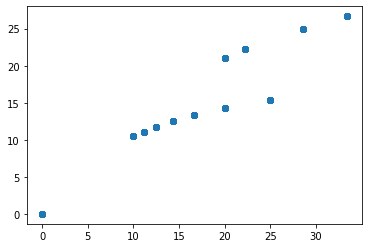

In [21]:
plt.scatter(df['dict_precision'], df['dict_f_measure'])


In [22]:
df
#df.loc['timestamp', ['tfidf_fire']].plot()


,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_questions,numb_of_emoticons,tweet_length,userFollowersCount,userFriendsCount,user_list_count,dict_precision,dict_recall,dict_f_measure
timestamp,,,,,,,,,,,,
2019-08-06 15:31:49,1158762608415010816.000,3.000,19.000,9.000,0.000,68.000,1592.000,523.000,94.000,20.000,11.110,14.290
2019-08-06 15:28:06,1158761674947596288.000,9.000,28.000,8.000,0.000,70.000,33.000,0.000,4.000,16.670,11.110,13.330
2019-08-06 15:21:11,1158759933766176768.000,5.000,37.000,12.000,0.000,57.000,220.000,61.000,3.000,33.330,22.220,26.670
2019-08-06 15:18:46,1158759326091227136.000,7.000,47.000,15.000,0.000,80.000,106.000,124.000,0.000,22.220,22.220,22.220
2019-08-06 15:17:58,1158759125603323904.000,3.000,65.000,8.000,0.000,57.000,550.000,720.000,7.000,14.290,11.110,12.500
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 17:39:12,1158432277694521344.000,5.000,41.000,14.000,0.000,93.000,303.000,1465.000,11.000,11.110,11.110,11.110
2019-08-05 17:36:34,1158431616995344384.000,14.000,44.000,15.000,0.000,92.000,51.000,272.000,4.000,0.000,0.000,0.000
2019-08-05 17:21:12,1158427750069182464.000,3.000,60.000,48.000,0.000,256.000,382.000,16.000,4.000,0.000,0.000,0.000


In [23]:
X['timestamp'] = X.index.hour

# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X['timestamp'], prefix='timestamp', drop_first=True)

# Add all the columns to the model data
X = X.join(add_var)

# Drop the original column that was expanded
X.drop(columns=['timestamp'], inplace=True)

In [24]:
df

,tweet_id_str,positive_sentiment,negative_sentiment,numb_of_questions,numb_of_emoticons,tweet_length,userFollowersCount,userFriendsCount,user_list_count,dict_precision,dict_recall,dict_f_measure
timestamp,,,,,,,,,,,,
2019-08-06 15:31:49,1158762608415010816.000,3.000,19.000,9.000,0.000,68.000,1592.000,523.000,94.000,20.000,11.110,14.290
2019-08-06 15:28:06,1158761674947596288.000,9.000,28.000,8.000,0.000,70.000,33.000,0.000,4.000,16.670,11.110,13.330
2019-08-06 15:21:11,1158759933766176768.000,5.000,37.000,12.000,0.000,57.000,220.000,61.000,3.000,33.330,22.220,26.670
2019-08-06 15:18:46,1158759326091227136.000,7.000,47.000,15.000,0.000,80.000,106.000,124.000,0.000,22.220,22.220,22.220
2019-08-06 15:17:58,1158759125603323904.000,3.000,65.000,8.000,0.000,57.000,550.000,720.000,7.000,14.290,11.110,12.500
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 17:39:12,1158432277694521344.000,5.000,41.000,14.000,0.000,93.000,303.000,1465.000,11.000,11.110,11.110,11.110
2019-08-05 17:36:34,1158431616995344384.000,14.000,44.000,15.000,0.000,92.000,51.000,272.000,4.000,0.000,0.000,0.000
2019-08-05 17:21:12,1158427750069182464.000,3.000,60.000,48.000,0.000,256.000,382.000,16.000,4.000,0.000,0.000,0.000


In [52]:

# NW

# Instantiate a new model
model = LinearRegression()

scores = []

# 
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

#
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 scores.append(model.score(X.iloc[test,:], y.iloc[test,:]))

print(scores)

'''
# [0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]
# [-0.6169762419006477, -5.327780612244896, -3.6370408163265298, -0.5634744476302915, -0.18762332351511324]
# [-0.00437235175323103, -0.00258666225466353, -0.0009634590686360411, -0.0001166286295464225, -0.0008683094428452165]
Uncommented all the other fields
[0.011277203797929847, 0.06362292338592934, 0.056278015573341, 0.08158179331144011]

'''


[0.011277203797929847, 0.06362292338592934, 0.056278015573341, 0.08158179331144011]


'\n\n# [0.3369114843455352, 0.36012522754170384, 0.5287437875934085, 0.5775024426976063, 0.5476392189848873]\n# [-0.6169762419006477, -5.327780612244896, -3.6370408163265298, -0.5634744476302915, -0.18762332351511324]\n# [-0.00437235175323103, -0.00258666225466353, -0.0009634590686360411, -0.0001166286295464225, -0.0008683094428452165]\n\nUncommented all the other fields\n[0.011277203797929847, 0.06362292338592934, 0.056278015573341, 0.08158179331144011]\n\n\n'

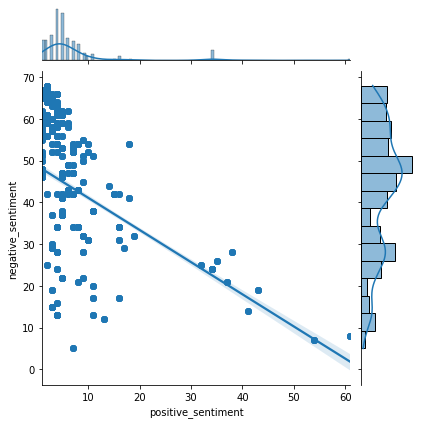

In [26]:
sns.jointplot(x=df['positive_sentiment'], y=df['negative_sentiment'], data=df, kind='reg')


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


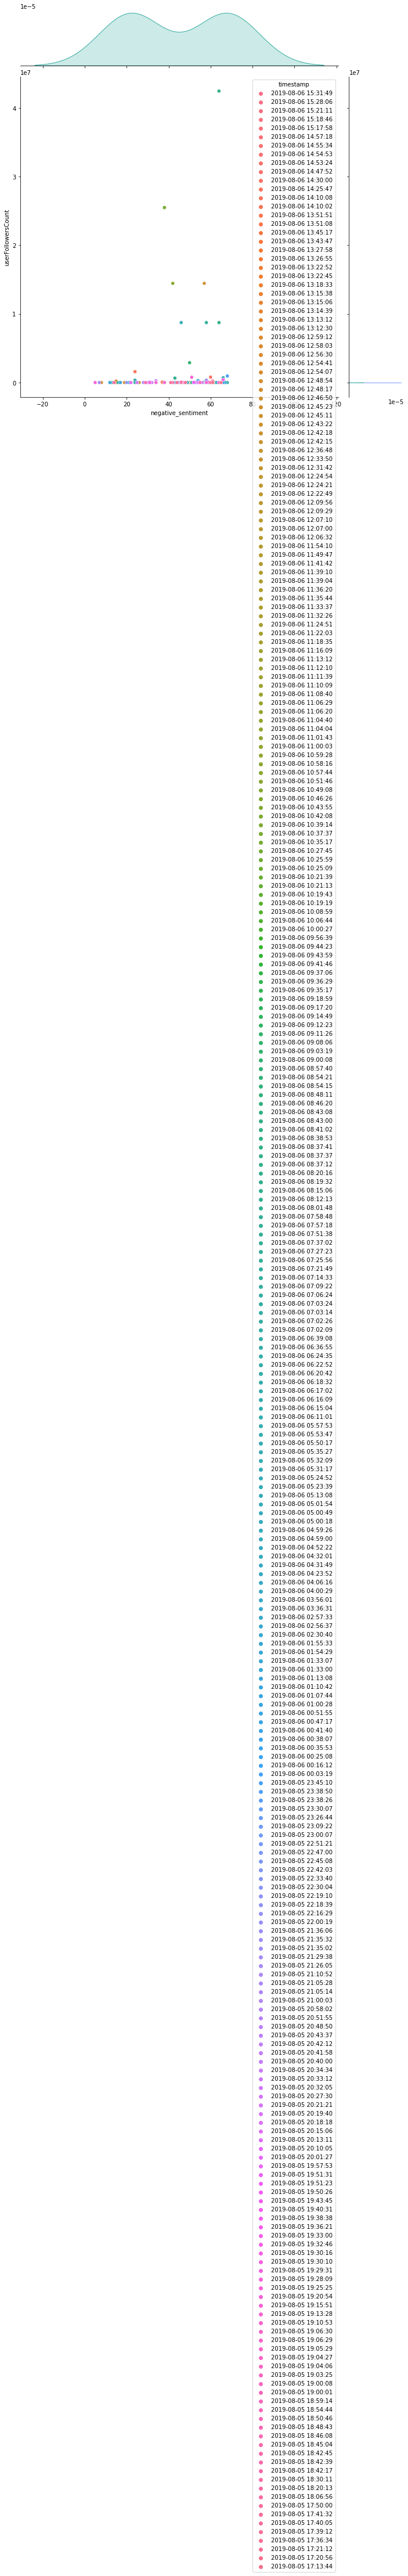

In [27]:

sns.jointplot(data=df, x="negative_sentiment", y="userFollowersCount", hue="timestamp",height = 10)


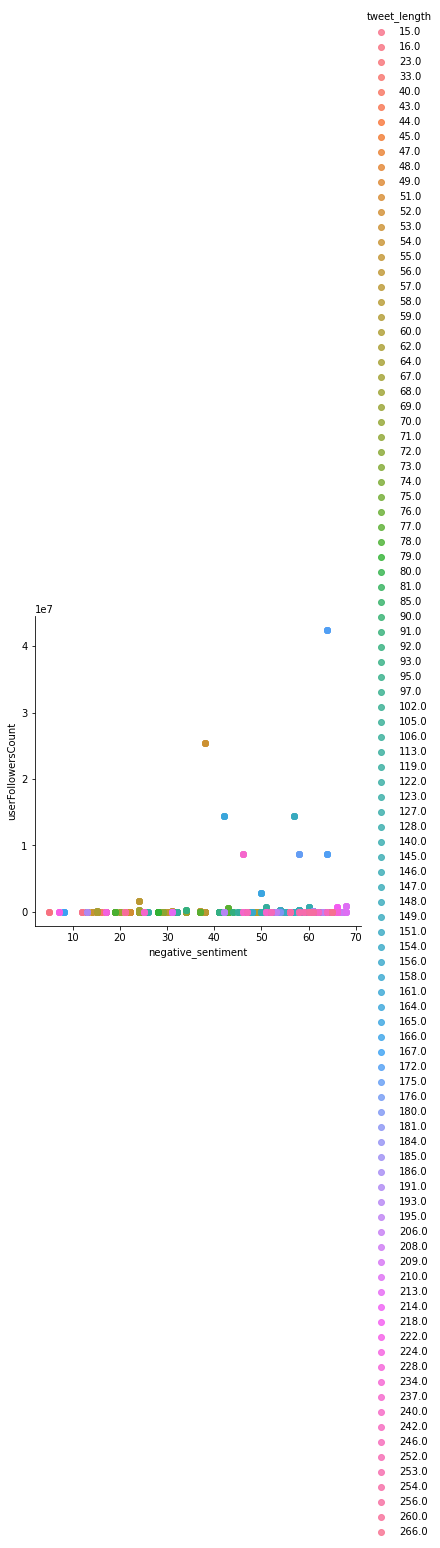

In [28]:
sns.lmplot(x='negative_sentiment', y='userFollowersCount', hue='tweet_length', data=df, fit_reg=False)


In [30]:
'''
# Convert it to "long-form" or "tidy" representation
df = pd.melt(df, id_vars=["timestamp"], var_name="dict_f_measure")

# Plot the average value by condition and date
ax = df.groupby(["dict_f_measure", "timestamp"]).mean().unstack("dict_f_measure").plot()

# Get a reference to the x-points corresponding to the dates and the the colors
x = np.arange(len(df.date.unique()))
palette = sns.color_palette()

# Calculate the 25th and 75th percentiles of the data
# and plot a translucent band between them
for cond, cond_df in df.groupby("dict_f_measure"):
    low = cond_df.groupby("timestamp").value.apply(np.percentile, 25)
    high = cond_df.groupby("timestamp").value.apply(np.percentile, 75)
    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))
'''

'\n# Convert it to "long-form" or "tidy" representation\ndf = pd.melt(df, id_vars=["timestamp"], var_name="dict_f_measure")\n\n# Plot the average value by condition and date\nax = df.groupby(["dict_f_measure", "timestamp"]).mean().unstack("dict_f_measure").plot()\n\n# Get a reference to the x-points corresponding to the dates and the the colors\nx = np.arange(len(df.date.unique()))\npalette = sns.color_palette()\n\n# Calculate the 25th and 75th percentiles of the data\n# and plot a translucent band between them\nfor cond, cond_df in df.groupby("dict_f_measure"):\n    low = cond_df.groupby("timestamp").value.apply(np.percentile, 25)\n    high = cond_df.groupby("timestamp").value.apply(np.percentile, 75)\n    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))\n'

In [32]:
'''
td = datetime.date.today()

#Set news outlet colors
colors1 = ["lightblue", 'green', 'red', 'blue', 'yellow']

#plot the data
fig, ax = plt.subplots()

g1 = ax.bar(df['negative_sentiment'], df['dict_f_measure'], color = colors1, alpha=0.7, align="center")

# Give chart labels and a tile
plt.title(f"Overall Sentiment based on Twitter ({td.strftime('%m/%d/%y')})")
plt.ylabel("Tweet Polarity")
plt.ylim(None,0.06)

def autolabel(rects):
    """
    Attach a text label for each bar displaying its value
    """
    for rect in rects:
        height = rect.get_height()
        if height < 0:
            ax.text(rect.get_x() + rect.get_width()/2, height*0.3,
                '%.3f' % float(height),
                ha='center', va='bottom')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height*0.1,
                '%.3f' % float(height),
                ha='center', va='bottom')
        
autolabel(g1)
'''

'\ntd = datetime.date.today()\n\n#Set news outlet colors\ncolors1 = ["lightblue", \'green\', \'red\', \'blue\', \'yellow\']\n\n#plot the data\nfig, ax = plt.subplots()\n\ng1 = ax.bar(df[\'negative_sentiment\'], df[\'dict_f_measure\'], color = colors1, alpha=0.7, align="center")\n\n# Give chart labels and a tile\nplt.title(f"Overall Sentiment based on Twitter ({td.strftime(\'%m/%d/%y\')})")\nplt.ylabel("Tweet Polarity")\nplt.ylim(None,0.06)\n\ndef autolabel(rects):\n    """\n    Attach a text label for each bar displaying its value\n    """\n    for rect in rects:\n        height = rect.get_height()\n        if height < 0:\n            ax.text(rect.get_x() + rect.get_width()/2, height*0.3,\n                \'%.3f\' % float(height),\n                ha=\'center\', va=\'bottom\')\n        else:\n            ax.text(rect.get_x() + rect.get_width()/2, height*0.1,\n                \'%.3f\' % float(height),\n                ha=\'center\', va=\'bottom\')\n        \nautolabel(g1)\n'

In [35]:
'''
# NW https://github.com/SSaishruthi/Linear_Regression_Detailed_Implementation/blob/master/Linear_Regression.ipynb
x_train, x_test, y_train, y_test = train_test_split(df['negative_sentiment'], df['dict_f_measure'], test_size=0.2, random_state=42)
x_train = np.reshape(x_train, (-1,1))
x_test = np.reshape(x_test, (-1,1))
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

#
print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)
'''

"\n# NW https://github.com/SSaishruthi/Linear_Regression_Detailed_Implementation/blob/master/Linear_Regression.ipynb\nx_train, x_test, y_train, y_test = train_test_split(df['negative_sentiment'], df['dict_f_measure'], test_size=0.2, random_state=42)\nx_train = np.reshape(x_train, (-1,1))\nx_test = np.reshape(x_test, (-1,1))\ny_train = np.reshape(y_train, (-1,1))\ny_test = np.reshape(y_test, (-1,1))\n\n#\nprint('Train - Predictors shape', x_train.shape)\nprint('Test - Predictors shape', x_test.shape)\nprint('Train - Target shape', y_train.shape)\nprint('Test - Target shape', y_test.shape)\n"

In [36]:
df.shape

(1433, 12)

In [37]:
m=df.groupby('dict_f_measure')[['negative_sentiment']].std()
n=df.groupby('dict_f_measure')[['positive_sentiment']].std()



In [38]:
m

,negative_sentiment
dict_f_measure,
0.000,13.398
10.530,15.588
11.110,6.552
11.760,11.936
12.500,6.693
13.330,6.247
14.290,3.386
15.380,0.870
21.050,3.750


In [39]:
x=pd.merge(m, n, on='dict_f_measure')


In [40]:
x

,negative_sentiment,positive_sentiment
dict_f_measure,,
0.000,13.398,8.764
10.530,15.588,11.751
11.110,6.552,1.134
11.760,11.936,8.443
12.500,6.693,2.764
13.330,6.247,14.283
14.290,3.386,1.647
15.380,0.870,0.000
21.050,3.750,0.479


In [41]:

'''
with open("../../../../data/raw/data/2020/2020-A/labels/TRECIS-2018-2020A-labels.json", "r") as in_file:
    for line in in_file:
        tweet_top = json.loads(line)
        tweet = json.loads(tweet_top["allProperties"]["srcjson"])
        tweet_id_map[np.int64(tweet["id"])] = tweet
    
with open("../../../../data/raw/data/2020/2020-A/labels/TRECIS-2018-2020A-labels.json", "r") as in_file:
    for line in in_file:
        
        tweet = json.loads(line)
        print(tweet)
        tweet_id_map[np.int64(tweet["eventID"])] = tweet

print("Total Tweet Count:", len(tweet_id_map))
''' 
tweet_id_map = df



In [44]:
category_to_label = {c:i+1 for i, c in enumerate(tweet_category_map.keys()) if c != "Irrelevant"}
category_to_label["Irrelevant"] = 0

tweet_id_to_category = {}
for category, tweet_ids in tweet_category_map.items():
    if ( len(tweet_ids) < 5 ):
        print("Skipping category:", category)
        continue
        
    for tweet_id in tweet_ids:
        tweet_id_to_category[np.int64(tweet_id)] = category_to_label[category]

tweet_id_to_category        

Skipping category: CleanUp
Skipping category: Hashtags
Skipping category: Volunteer


{243413475681001473: 1,
 213689735082807296: 1,
 212221690904723458: 1,
 217393586537377792: 1,
 378071202931032064: 1,
 379319536878510082: 1,
 379284581548949504: 1,
 379222237393719296: 1,
 378174277947645952: 1,
 378059840569880576: 1,
 378175691449069568: 1,
 379325744440041472: 1,
 378216451670171648: 1,
 379264868286599168: 1,
 378205533913632769: 1,
 378073551749648384: 1,
 379245721288851456: 1,
 378047710659502080: 1,
 378130011292979200: 1,
 275670412313104385: 1,
 275241657971130369: 1,
 275132912259698689: 1,
 275860741461000192: 1,
 275263749382881280: 1,
 275237581124407296: 1,
 275065346233335808: 1,
 275514925269536769: 1,
 275117779202494464: 1,
 275801358479798273: 1,
 396331482911735808: 1,
 396331961058209792: 1,
 396328030986985472: 1,
 396322142184169472: 1,
 396335685570793472: 1,
 324732234781302784: 1,
 324730800346124291: 1,
 324735942541836289: 1,
 324729281999691777: 1,
 324736970154721280: 1,
 244127337828986880: 3,
 243383138254999552: 3,
 379122991780888

# Classification

In [43]:
tweet_pairs = []
y_data = []

# Turn the labels into an indexer
indexer = {c:i for i, c in enumerate(list(category_to_label.keys()))}
print("test" , indexer)


# Reverse the polarity
indexer_inv = {i:c for c,i in indexer.items()}


for tweet_id, categories in category_df.groupby("tweet_id"):

    tup = (
        tweet_id_map["tweet_id_str"] == np.int64(tweet_id), 
        [indexer[category] for category in categories["category"] if category != 'Unknown']
    )
    print("test" , tup)
    tweet_pairs.append(tup)

tweet_texts = [tp[0]["text"] for tp in tweet_pairs]

test {'Advice': 0, 'CleanUp': 1, 'ContextualInformation': 2, 'Discussion': 3, 'Donations': 4, 'EmergingThreats': 5, 'Factoid': 6, 'FirstPartyObservation': 7, 'Hashtags': 8, 'InformationWanted': 9, 'MovePeople': 10, 'MultimediaShare': 11, 'NewSubEvent': 12, 'News': 13, 'Official': 14, 'OriginalEvent': 15, 'Sentiment': 16, 'ServiceAvailable': 17, 'ThirdPartyObservation': 18, 'Volunteer': 19, 'Weather': 20, 'Irrelevant': 21}
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [21])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ..

Name: tweet_id_str, Length: 1433, dtype: bool, [6])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
             

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-

Name: tweet_id_str, Length: 1433, dtype: bool, [1])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [21])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [11])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
           

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [12])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [12])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-

Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [12])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [14])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [15])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [21])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [6])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
             

Name: tweet_id_str, Length: 1433, dtype: bool, [])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
            

Name: tweet_id_str, Length: 1433, dtype: bool, [18])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [0])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [21])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
           

Name: tweet_id_str, Length: 1433, dtype: bool, [14])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
            

Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [16])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [11])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [11])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
          

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [11])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [0])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-0

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [21])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [17])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-

test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-

Name: tweet_id_str, Length: 1433, dtype: bool, [0])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [6])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [7])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
             

Name: tweet_id_str, Length: 1433, dtype: bool, [6])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
           

Name: tweet_id_str, Length: 1433, dtype: bool, [13])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [6])
test (timestamp
2019-08-06 15:31:49    False
2019-08-06 15:28:06    False
2019-08-06 15:21:11    False
2019-08-06 15:18:46    False
2019-08-06 15:17:58    False
                       ...  
2019-08-05 17:39:12    False
2019-08-05 17:36:34    False
2019-08-05 17:21:12    False
2019-08-05 17:20:56    False
2019-08-05 17:13:44    False
Name: tweet_id_str, Length: 1433, dtype: bool, [13])


KeyError: 'text'

In [ ]:
tweet_pairs

In [ ]:
labeled_tweets_stock = {}
tweet_id_to_count_map = {}

labels_df = pd.read_json("../../../../data/raw/data/2020/2020-A/labels/TRECIS-2018-2020A-labels.json")

labels_df.info()



In [ ]:
labels_df

In [ ]:
# Get the postIDs from the labels
tweet_id = labels_df["postID"]
# Get the topics for each label
tweet_topic = labels_df['eventID']

tweet_topic

In [ ]:
#tweet_id_to_topic_map[tweet_id] = eventidTopicidMap[tweet_topic]
#tweet_id_to_count_map[tweet_id] = counter

for event, tweets in labels_df.groupby("eventID"):
    labeled_tweets_stock[event] = list(tweets["postID"])

# Maps all known twitter ids to events
labeled_tweets_stock

In [ ]:
tweet_id_to_topic_map = {}


counter = 1
    


# load each tweet
# tweet_entry = json.loads(line)

tweet_id = np.int64(df["tweet_id_str"])

print("tweet_id", tweet_id)
tweet_topic = "siberianWildfires2019" # tweet_entry["topic"] #get the topic from the run file
#tweet_topic = labeled_tweets_stock[tweet_id]

#tweet_topic
#tweet_id_to_topic_map[tweet_id] = eventidTopicidMap[tweet_topic]
#tweet_id_to_count_map[tweet_id] = counter

#counter += 1
print(tweet_id)
print(tweet_topic)

for id in tweet_id:
    for x in labeled_tweets_stock['siberianWildfires2020']:
        #print("x", x)
        if id == x:
            print(id)

# Get the matching tweet ids for the topic of the run
topic_tweet_id = labeled_tweets_stock['siberianWildfires2020']
topic_tweet_id

In [ ]:
df.head()

In [ ]:
len(tweet_id_to_count_map), priority_df.shape[0]

In [ ]:
set(tweet_id_to_count_map.keys()).difference(priority_df["tweet_id"])

In [ ]:
# Get the categories

# Get the columns ['category', 'inc_id', 'count', 'priority', 'label']

cols_list = [x for x in category_df.columns if x != "tweet_id"]

def row2labels(row):
    print(row)
    output = []
    for col in cols_list:
        print(col)
        if ( row[col] != 0 ):
            output.append(col)
            
    return output

cols_list

In [ ]:
category_map = {row["tweet_id"]: row2labels(row) for idx, row in category_df.iterrows()}
#category_map

In [ ]:
category_map
#category_map = ontologydf #eventidTopicidMap
category_map

In [ ]:
category_df["inc_id"] = category_df["tweet_id"].apply(tweet_id_to_topic_map.get)
category_df["count"] = category_df["tweet_id"].apply(tweet_id_to_count_map.get)
category_df["priority"] = category_df["tweet_id"].apply(priority_map.get)
category_df["label"] = category_df["tweet_id"].apply(category_map.get)

In [ ]:
category_df['priority'] = category_df['priority'].replace(np.nan,0)

In [ ]:
priority_scorer = {
    'Critical' : 0.75,
    'High' : 0.75,
    'Medium' : 0.50,
    'Low' : 0.25,
    'Unknown' : 0.0,
}

# write to .run file
with open("marks.run" , "w") as out_file:
    for row in category_df.drop_duplicates(subset="tweet_id").itertuples():
        print("row:", row)
        content = [
            "TRECIS-CTIT-H-Test-046",
            #row.inc_id,     # category
            "Q0",           # static `Q0`
            row.tweet_id,   # 
            getattr(row, 'Index'),
            row.priority, # priority_scorer[row.priority], # Priority
            #row.category,
            str(row.category).replace("'", '"'),
            "marksrun"
        ]
        out_file.write("\t".join([str(x) for x in content]) + "\n")

In [ ]:
'''
Format Required

1. Incident Identifier
2. static `Q0`
3. tweetID (18-19 digit number)
4. Index (start at 1)
5. Priority label (0-1)
6. JSON array for information types
7. Runtag, UID
'''
